In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from scipy.ndimage.filters import gaussian_filter1d
import pandasql as ps
import warnings
from pylab import rcParams
from scipy.stats import f_oneway
from scipy.stats import ttest_ind


In [2]:
# Read File
file = r'C:\Users\Joel\Dropbox\Vitrual Internships\Quantium\Task 1\Data\QVI_transaction_data.csv'
data = pd.read_csv(file, index_col = None)
data.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


# Data Cleaning and Feature Engineering

In [3]:
# Extract packet size from product name
data['PACKET_SIZE'] = data.PROD_NAME.str.extract('(\d+)')
data['PACKET_SIZE'] = data['PACKET_SIZE'].astype(str).astype(int)

# Extract brand name from product name
data['BRAND_NAME'] = data['PROD_NAME'].str.split().str.get(0)

# Extract real date from excel form date
data['real_date'] = pd.TimedeltaIndex(data['DATE'], unit = 'd') + dt.datetime(1899,12,30)

# Only contain records which are chips (not salsa)
data = data[data['PROD_NAME'].str.contains('Salsa') == False]
data

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACKET_SIZE,BRAND_NAME,real_date
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,Natural,2018-10-17
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,175,CCs,2019-05-14
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,170,Smiths,2019-05-20
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,175,Smiths,2018-08-17
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,150,Kettle,2018-08-18
...,...,...,...,...,...,...,...,...,...,...,...
264831,43533,272,272319,270088,89,Kettle Sweet Chilli And Sour Cream 175g,2,10.8,175,Kettle,2019-03-09
264832,43325,272,272358,270154,74,Tostitos Splash Of Lime 175g,1,4.4,175,Tostitos,2018-08-13
264833,43410,272,272379,270187,51,Doritos Mexicana 170g,2,8.8,170,Doritos,2018-11-06
264834,43461,272,272379,270188,42,Doritos Corn Chip Mexican Jalapeno 150g,2,7.8,150,Doritos,2018-12-27


# Check for Nulls

In [4]:
# Check nulls
data.isnull().sum()

DATE              0
STORE_NBR         0
LYLTY_CARD_NBR    0
TXN_ID            0
PROD_NBR          0
PROD_NAME         0
PROD_QTY          0
TOT_SALES         0
PACKET_SIZE       0
BRAND_NAME        0
real_date         0
dtype: int64

In [5]:
# Create clean df

df = data[['real_date', 'STORE_NBR','LYLTY_CARD_NBR', 'TXN_ID', 'PROD_NAME', 'BRAND_NAME', 'PACKET_SIZE', 'PROD_QTY', 'TOT_SALES']]
df.sort_values(by = ['real_date'], inplace = True, ignore_index = True)
df

<ipython-input-5-5a071f63a699>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values(by = ['real_date'], inplace = True, ignore_index = True)


,real_date,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NAME,BRAND_NAME,PACKET_SIZE,PROD_QTY,TOT_SALES
0,2018-07-01,9,9341,8808,Smiths Thinly Cut Roast Chicken 175g,Smiths,175,2,6.0
1,2018-07-01,86,86016,84237,Red Rock Deli Sp Salt & Truffle 150G,Red,150,2,5.4
2,2018-07-01,129,129046,132474,Smith Crinkle Cut Mac N Cheese 150g,Smith,150,2,5.2
3,2018-07-01,58,58072,53145,Pringles Sthrn FriedChicken 134g,Pringles,134,2,7.4
4,2018-07-01,97,97164,97311,WW Crinkle Cut Chicken 175g,WW,175,2,3.4
...,...,...,...,...,...,...,...,...,...
246737,2019-06-30,91,91076,89519,Thins Chips Seasonedchicken 175g,Thins,175,2,6.6
246738,2019-06-30,84,84116,83704,Doritos Corn Chips Nacho Cheese 170g,Doritos,170,2,8.8
246739,2019-06-30,24,24115,20917,Smiths Crinkle Cut Chips Chs&Onion170g,Smiths,170,2,5.8
246740,2019-06-30,199,199117,198068,Doritos Corn Chips Nacho Cheese 170g,Doritos,170,2,8.8


In [6]:
df['BRAND_NAME'].value_counts()

Kettle        41288
Smiths        27390
Pringles      25102
Doritos       22041
Thins         14075
RRD           11894
Infuzions     11057
WW            10320
Cobs           9693
Tostitos       9471
Twisties       9454
Tyrrells       6442
Grain          6272
Natural        6050
Cheezels       4603
CCs            4551
Red            4427
Dorito         3185
Infzns         3144
Smith          2963
Cheetos        2927
Snbts          1576
Burger         1564
Woolworths     1516
GrnWves        1468
Sunbites       1432
NCC            1419
French         1418
Name: BRAND_NAME, dtype: int64

In [7]:
# Check Unique Brand Instances
df.groupby('BRAND_NAME', group_keys=False).apply(lambda df: df.sample(1))

,real_date,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NAME,BRAND_NAME,PACKET_SIZE,PROD_QTY,TOT_SALES
139010,2019-01-22,57,57193,52384,Burger Rings 220g,Burger,220,2,4.6
116029,2018-12-19,63,63092,59946,CCs Nacho Cheese 175g,CCs,175,2,4.2
32416,2018-08-17,137,137245,140369,Cheetos Puffs 165g,Cheetos,165,1,2.8
37036,2018-08-24,223,223154,223863,Cheezels Cheese Box 125g,Cheezels,125,2,4.2
14984,2018-07-23,45,45156,41308,Cobs Popd Sour Crm &Chives Chips 110g,Cobs,110,2,7.6
126519,2019-01-04,152,152085,150764,Dorito Corn Chp Supreme 380g,Dorito,380,2,13.0
137647,2019-01-20,239,239151,243694,Doritos Corn Chips Nacho Cheese 170g,Doritos,170,2,8.8
54876,2018-09-20,205,205231,204295,French Fries Potato Chips 175g,French,175,2,6.0
17923,2018-07-27,150,150209,149463,Grain Waves Sweet Chilli 210g,Grain,210,2,7.2
70284,2018-10-12,172,172091,173294,GrnWves Plus Btroot & Chilli Jam 180g,GrnWves,180,2,6.2


In [8]:
# Combine Duplicate Brands
df['BRAND_NAME'].replace({'Burger':'Burger Rings',
                            'Dorito':'Doritos',
                            'French':'French Fries',
                            'Grain': 'GrnWves',
                            'Infzns':'Infuzions',
                            'Natural':'NCC',
                            'Old':'Old El Paso',
                            'Red':'RRD',
                            'Smith':'Smiths',
                            'Snbts':'Sunbites',
                            'WW':'Woolworths'}, inplace = True)

C:\Users\Joel\anaconda3\lib\site-packages\pandas\core\generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [9]:
df['BRAND_NAME'].value_counts()

Kettle          41288
Smiths          30353
Doritos         25226
Pringles        25102
RRD             16321
Infuzions       14201
Thins           14075
Woolworths      11836
Cobs             9693
Tostitos         9471
Twisties         9454
GrnWves          7740
NCC              7469
Tyrrells         6442
Cheezels         4603
CCs              4551
Sunbites         3008
Cheetos          2927
Burger Rings     1564
French Fries     1418
Name: BRAND_NAME, dtype: int64

# Check for Outliers

In [10]:
# Check for outliers in transactions
print(df['PROD_QTY'].describe())

count    246742.000000
mean          1.908062
std           0.659831
min           1.000000
25%           2.000000
50%           2.000000
75%           2.000000
max         200.000000
Name: PROD_QTY, dtype: float64


- Seems like an outlier of 200 purchases, may be a bulk order for business

In [11]:
# Check the features for records over 6
df[df['PROD_QTY'] > 6]

,real_date,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NAME,BRAND_NAME,PACKET_SIZE,PROD_QTY,TOT_SALES
33534,2018-08-19,226,226000,226201,Dorito Corn Chp Supreme 380g,Doritos,380,200,650.0
218684,2019-05-20,226,226000,226210,Dorito Corn Chp Supreme 380g,Doritos,380,200,650.0


In [12]:
# Appears to be the same customer, did that customer have any other transactions? if not then drop those outliers
df[df['LYLTY_CARD_NBR'] == 226000]

,real_date,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NAME,BRAND_NAME,PACKET_SIZE,PROD_QTY,TOT_SALES
33534,2018-08-19,226,226000,226201,Dorito Corn Chp Supreme 380g,Doritos,380,200,650.0
218684,2019-05-20,226,226000,226210,Dorito Corn Chp Supreme 380g,Doritos,380,200,650.0


In [13]:
# Drop those rows
df.drop(df[df.LYLTY_CARD_NBR == 226000].index, inplace = True)

C:\Users\Joel\anaconda3\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [14]:
# Check dropped rows
df[df['LYLTY_CARD_NBR'] == 226000]

,real_date,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NAME,BRAND_NAME,PACKET_SIZE,PROD_QTY,TOT_SALES


# Check for complete dates

In [15]:
print(df['real_date'].value_counts())

2018-12-24    865
2018-12-23    853
2018-12-22    840
2018-12-19    839
2018-12-20    808
             ... 
2019-06-24    612
2018-10-18    611
2018-11-25    610
2018-09-22    609
2019-06-13    607
Name: real_date, Length: 364, dtype: int64


- It appears we are missing one day of data.

In [16]:
# Find date which is missing for FY 2018-2019
pd.date_range(start = '2018-07-01', end = '2019-06-30').difference(df['real_date'])

DatetimeIndex(['2018-12-25'], dtype='datetime64[ns]', freq=None)

- Date missing is christmas day, which is a public holiday. We can assume this particular business did not operate on that day.

# Describe Data and Check Correlation

In [17]:
df.describe()

,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PACKET_SIZE,PROD_QTY,TOT_SALES
count,246740.000000,2.467400e+05,2.467400e+05,246740.000000,246740.000000,246740.000000
mean,135.050361,1.355303e+05,1.351304e+05,175.583521,1.906456,7.316113
std,76.786971,8.071520e+04,7.814760e+04,59.432118,0.342499,2.474897
min,1.000000,1.000000e+03,1.000000e+00,70.000000,1.000000,1.700000
25%,70.000000,7.001500e+04,6.756875e+04,150.000000,2.000000,5.800000
50%,130.000000,1.303670e+05,1.351815e+05,170.000000,2.000000,7.400000
75%,203.000000,2.030832e+05,2.026522e+05,175.000000,2.000000,8.800000
max,272.000000,2.373711e+06,2.415841e+06,380.000000,5.000000,29.500000


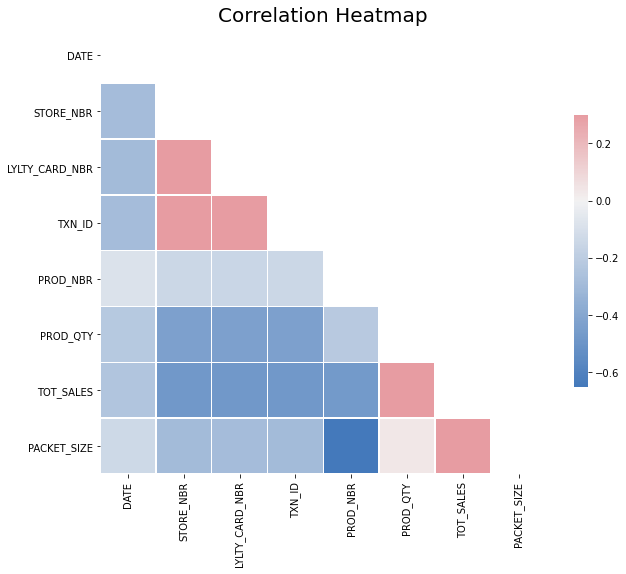

In [18]:
# Correlation
data_corr = data.corr()

corr = data_corr.corr()

mask = np.triu(np.ones_like(corr, dtype=np.bool))

f, ax = plt.subplots(figsize=(10, 10))

cmap = sns.diverging_palette(250, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Heatmap', fontsize = 20)

plt.show()

# Transactions Through the Year

In [19]:
# Create Dataframe for transaction counts
transactions = pd.DataFrame.from_dict(dict(df['real_date'].value_counts()), orient = 'index', columns = ['transactions'])
transactions.reset_index(inplace = True)
transactions.rename(columns = {'index': 'date'}, inplace = True)
transactions.sort_values(by = 'date', inplace = True)
transactions

,date,transactions
252,2018-07-01,663
302,2018-07-02,650
177,2018-07-03,674
214,2018-07-04,669
266,2018-07-05,660
...,...,...
280,2019-06-26,657
211,2019-06-27,669
185,2019-06-28,673
56,2019-06-29,703


Text(0.5, 1.0, 'Number of Transactions Over FY18-19')

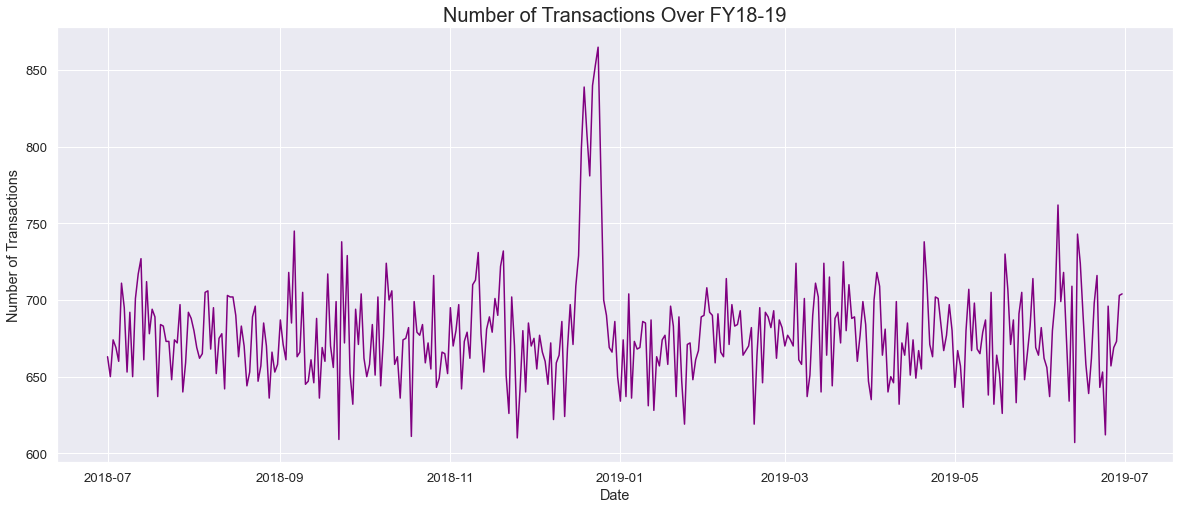

In [20]:
plt.figure(figsize = (20,8))
sns.set_style('darkgrid')
sns.set_context('notebook', font_scale = 1.2)
sns.lineplot(data = transactions, x = 'date', y = 'transactions', palette = 'rocket', color = 'purple')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.title('Number of Transactions Over FY18-19', fontsize = 20)

OBSERVATIONS:
- We see a large increase in sales building up to christmas, and a sudden drop off afterwards back to the regular amount. The data does not inculde the drop to 0 sales on christmas day due to closure on the 25th. 

- Data shows no significant outliers besides december sales, which is already explained by lead up to christmas period.

# Pack Size Analysis

In [21]:
# List all types of packet sizes
pack_sizes = pd.DataFrame.from_dict(dict(df['PACKET_SIZE'].value_counts()), orient = 'index', columns = ['counts'])
pack_sizes.reset_index(inplace = True)
pack_sizes.rename(columns = {'index':'size (g)'}, inplace = True)
pack_sizes.sort_values(by = 'size (g)', inplace = True)
pack_sizes

,size (g),counts
17,70,1507
13,90,3008
3,110,22387
19,125,1454
2,134,25102
11,135,3257
1,150,40203
15,160,2970
5,165,15297
4,170,19983


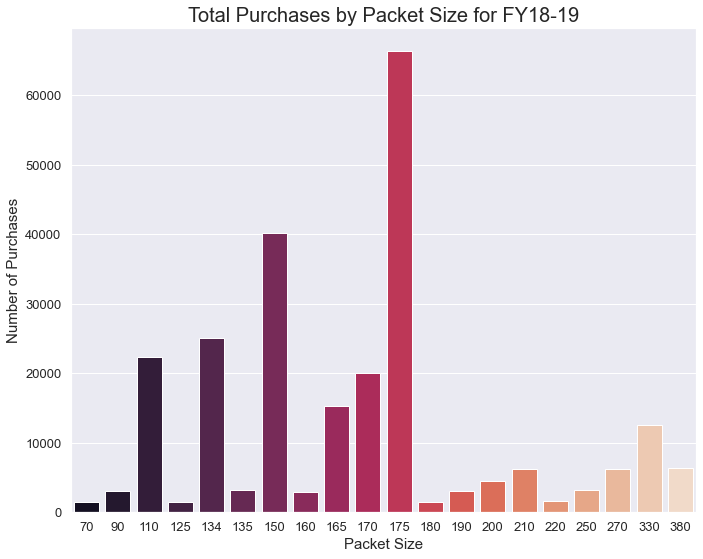

In [22]:
plt.figure(figsize = (10,8))
ax = sns.set_style('darkgrid')
ax = sns.barplot(x = pack_sizes['size (g)'], y = pack_sizes['counts'], palette = 'rocket')
ax.set_xlabel('Packet Size', fontsize = 15)
ax.set_ylabel('Number of Purchases', fontsize = 15)
ax.axes.set_title('Total Purchases by Packet Size for FY18-19', fontsize = 20)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.tight_layout()

OBSERVATIONS:
- The smallest packet is 70g, whilst the upper range goes up to 380g pakcets.
- The most common packet is 175g.
- In the histogram, we see that the upper ranges of packet sizes are not as popular.
- We see a common pattern with distribution, with 110g, 134g, 150g, and 175g topping the purchases. This may be indication that consumers see these sizes being the best value for money.

# Brand Analysis

In [23]:
df['BRAND_NAME'].describe()

count     246740
unique        20
top       Kettle
freq       41288
Name: BRAND_NAME, dtype: object

In [24]:
brand_name_dist = dict(df['BRAND_NAME'].value_counts())
brands = pd.DataFrame.from_dict(data = brand_name_dist,columns = ['Stock Sold'], orient = 'index')
brands

,Stock Sold
Kettle,41288
Smiths,30353
Doritos,25224
Pringles,25102
RRD,16321
Infuzions,14201
Thins,14075
Woolworths,11836
Cobs,9693
Tostitos,9471


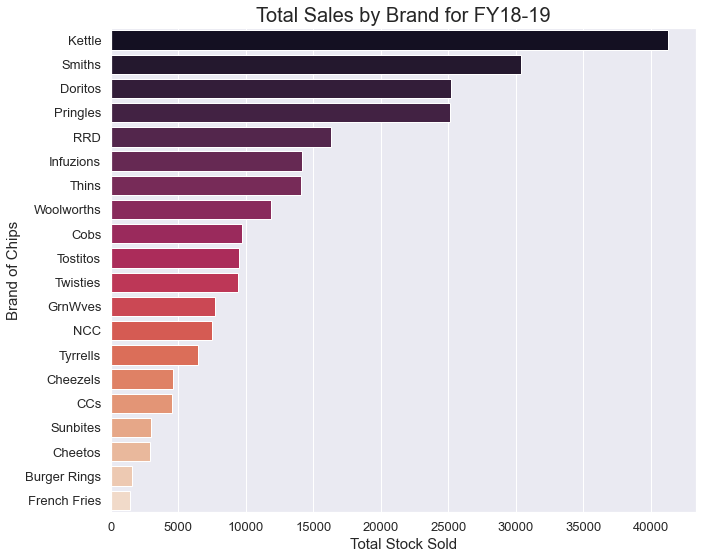

In [25]:
plt.figure(figsize = (10,8))
ax = sns.set_style('darkgrid')
ax = sns.barplot(x = brands['Stock Sold'], y = brands.index, palette = 'rocket')
ax.set_xlabel('Total Stock Sold', fontsize = 15)
ax.set_ylabel('Brand of Chips', fontsize = 15)
ax.axes.set_title('Total Sales by Brand for FY18-19', fontsize = 20)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.tight_layout()

PRELIMINARY OBSERVATONS:
- Kettle is the most popular brand ofchips
- Followed by Smiths
- Dirotis and Pringles are relatively equal in terms of popularity
- Burger Rings and French Fries are the least popular

# Customer Data

In [26]:
# import data
file = r'C:\Users\Joel\Dropbox\Vitrual Internships\Quantium\Task 1\Data\QVI_purchase_behaviour.csv'
data2 = pd.read_csv(file, index_col = None)
data2

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream
...,...,...,...
72632,2370651,MIDAGE SINGLES/COUPLES,Mainstream
72633,2370701,YOUNG FAMILIES,Mainstream
72634,2370751,YOUNG FAMILIES,Premium
72635,2370961,OLDER FAMILIES,Budget


In [27]:
# Check for nulls
data2.isnull().sum()

LYLTY_CARD_NBR      0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
dtype: int64

In [28]:
# Check value counts for duplicate customers
data2['LYLTY_CARD_NBR'].value_counts()

2047      1
197109    1
121326    1
119279    1
74225     1
         ..
251088    1
77007     1
81101     1
79052     1
131072    1
Name: LYLTY_CARD_NBR, Length: 72637, dtype: int64

- Length matches length of data frame, no duplicate customer id's.

# Customer Lifestage Segments

In [29]:
data2['LIFESTAGE'].describe()

count        72637
unique           7
top       RETIREES
freq         14805
Name: LIFESTAGE, dtype: object

In [30]:
data2['LIFESTAGE'].value_counts()

RETIREES                  14805
OLDER SINGLES/COUPLES     14609
YOUNG SINGLES/COUPLES     14441
OLDER FAMILIES             9780
YOUNG FAMILIES             9178
MIDAGE SINGLES/COUPLES     7275
NEW FAMILIES               2549
Name: LIFESTAGE, dtype: int64

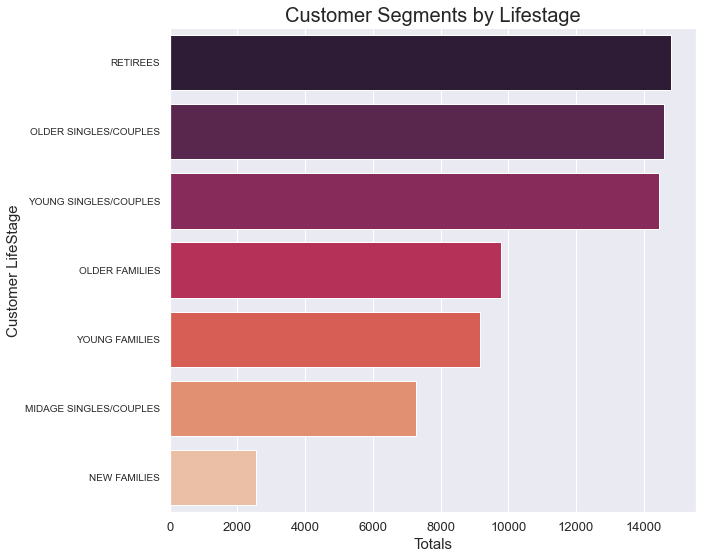

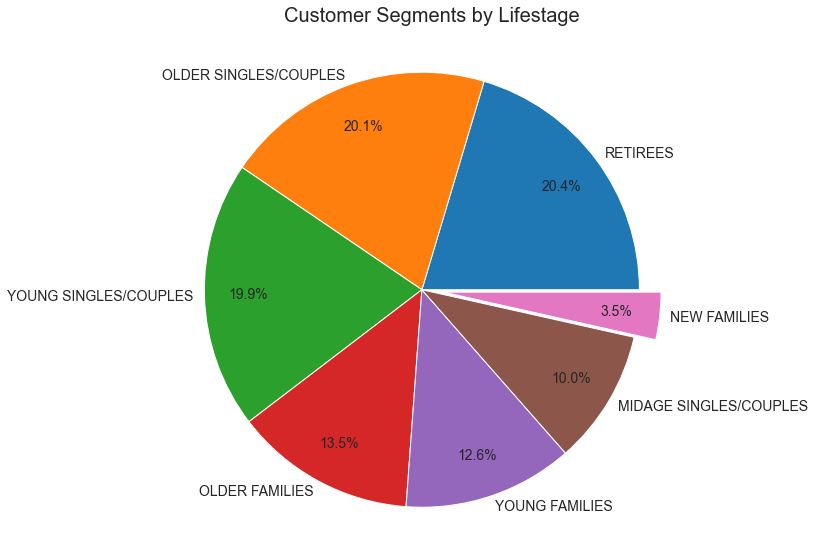

In [31]:
# Make DataFrame
lifestage = pd.DataFrame.from_dict(dict(data2['LIFESTAGE'].value_counts()), orient = 'index', columns = ['Counts'])

# Show Distribution
plt.figure(figsize = (10,8))
ax = sns.set_style('darkgrid')
ax = sns.barplot(y = lifestage.index, x = lifestage['Counts'], palette = 'rocket')
ax.set_ylabel('Customer LifeStage', fontsize = 15)
ax.set_xlabel('Totals', fontsize = 15)
ax.axes.set_title('Customer Segments by Lifestage', fontsize = 20)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 10)
plt.tight_layout()

# Show Proportions
# Pie chart
pie, ax = plt.subplots(figsize = (10, 8))
labels = lifestage.index
plt.pie(x = lifestage['Counts'], autopct="%.1f%%", explode=(0, 0, 0, 0, 0, 0, .05), labels=labels, pctdistance=0.8, labeldistance = 1.05, textprops = {'fontsize': 14}, radius = 0.5)
plt.title("Customer Segments by Lifestage", fontsize=20)
ax.axis('square')
plt.tight_layout()

- Business categorizes this segment into 7 classes.
- Majority of customers are either retirees or older/younger singles/couples, being 20.4%, 20.1% and 19.9% respectively, making up 60.4% of the population.

# Customer Type Segments

In [32]:
data2['PREMIUM_CUSTOMER'].value_counts()

Mainstream    29245
Budget        24470
Premium       18922
Name: PREMIUM_CUSTOMER, dtype: int64

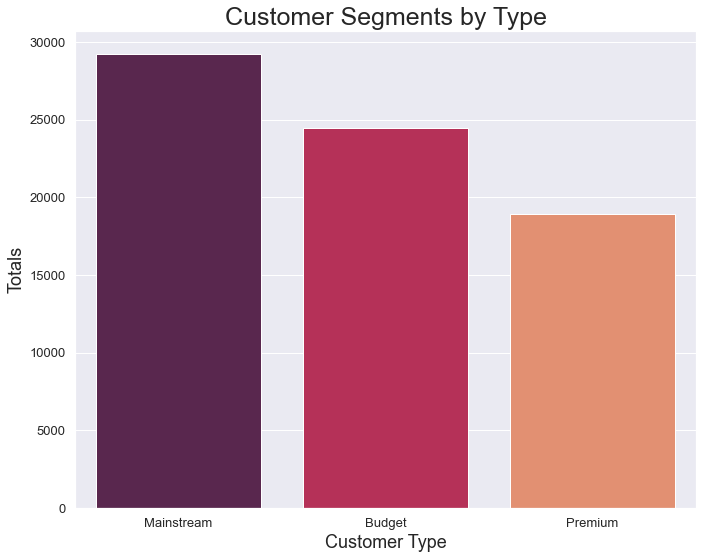

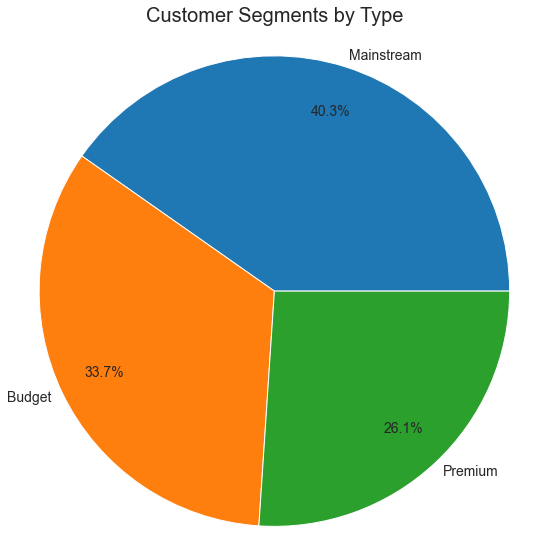

In [33]:
# Make DataFrame
cstype = pd.DataFrame.from_dict(dict(data2['PREMIUM_CUSTOMER'].value_counts()), orient = 'index', columns = ['Counts'])

# Show Distribution
plt.figure(figsize = (10,8))
ax = sns.set_style('darkgrid')
ax = sns.barplot(x = cstype.index, y = cstype['Counts'], palette = 'rocket')
ax.set_xlabel('Customer Type', fontsize = 18)
ax.set_ylabel('Totals', fontsize = 18)
ax.axes.set_title('Customer Segments by Type', fontsize = 25)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.tight_layout()

# Show proportionate distribution (Pie Chart)
pie, ax = plt.subplots(figsize = (10, 8))
labels = cstype.index
plt.pie(x = cstype['Counts'], autopct="%.1f%%", labels=labels, pctdistance=0.8, labeldistance = 1.05, textprops = {'fontsize': 14}, radius = 0.5)
plt.title("Customer Segments by Type", fontsize=20)
ax.axis('square')
plt.tight_layout()

# Merging the 2 Datasets

In [34]:
df

,real_date,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NAME,BRAND_NAME,PACKET_SIZE,PROD_QTY,TOT_SALES
0,2018-07-01,9,9341,8808,Smiths Thinly Cut Roast Chicken 175g,Smiths,175,2,6.0
1,2018-07-01,86,86016,84237,Red Rock Deli Sp Salt & Truffle 150G,RRD,150,2,5.4
2,2018-07-01,129,129046,132474,Smith Crinkle Cut Mac N Cheese 150g,Smiths,150,2,5.2
3,2018-07-01,58,58072,53145,Pringles Sthrn FriedChicken 134g,Pringles,134,2,7.4
4,2018-07-01,97,97164,97311,WW Crinkle Cut Chicken 175g,Woolworths,175,2,3.4
...,...,...,...,...,...,...,...,...,...
246737,2019-06-30,91,91076,89519,Thins Chips Seasonedchicken 175g,Thins,175,2,6.6
246738,2019-06-30,84,84116,83704,Doritos Corn Chips Nacho Cheese 170g,Doritos,170,2,8.8
246739,2019-06-30,24,24115,20917,Smiths Crinkle Cut Chips Chs&Onion170g,Smiths,170,2,5.8
246740,2019-06-30,199,199117,198068,Doritos Corn Chips Nacho Cheese 170g,Doritos,170,2,8.8


In [35]:
data2

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream
...,...,...,...
72632,2370651,MIDAGE SINGLES/COUPLES,Mainstream
72633,2370701,YOUNG FAMILIES,Mainstream
72634,2370751,YOUNG FAMILIES,Premium
72635,2370961,OLDER FAMILIES,Budget


In [36]:
# LEFT JOIN using SQL
query = """
        SELECT df.real_date,
                df.STORE_NBR,
                df.TXN_ID,
                df.PROD_NAME,
                df.BRAND_NAME,
                df.PACKET_SIZE,
                df.PROD_QTY,
                df.TOT_SALES,
                df.LYLTY_CARD_NBR,
                data2.LIFESTAGE,
                data2.PREMIUM_CUSTOMER
        FROM df
        LEFT JOIN data2
        ON df.LYLTY_CARD_NBR = data2.LYLTY_CARD_NBR
        """
data = ps.sqldf(query, locals())

# Convert datetime to just date
data['real_date'] = pd.to_datetime(df['real_date']).dt.date

# Display merged dataframe
data

,real_date,STORE_NBR,TXN_ID,PROD_NAME,BRAND_NAME,PACKET_SIZE,PROD_QTY,TOT_SALES,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,2018-07-01,9,8808,Smiths Thinly Cut Roast Chicken 175g,Smiths,175,2,6.0,9341,RETIREES,Budget
1,2018-07-01,86,84237,Red Rock Deli Sp Salt & Truffle 150G,RRD,150,2,5.4,86016,RETIREES,Mainstream
2,2018-07-01,129,132474,Smith Crinkle Cut Mac N Cheese 150g,Smiths,150,2,5.2,129046,OLDER SINGLES/COUPLES,Premium
3,2018-07-01,58,53145,Pringles Sthrn FriedChicken 134g,Pringles,134,2,7.4,58072,OLDER SINGLES/COUPLES,Premium
4,2018-07-01,97,97311,WW Crinkle Cut Chicken 175g,Woolworths,175,2,3.4,97164,OLDER FAMILIES,Premium
...,...,...,...,...,...,...,...,...,...,...,...
246735,2019-06-30,91,89519,Thins Chips Seasonedchicken 175g,Thins,175,2,6.6,91076,YOUNG SINGLES/COUPLES,Mainstream
246736,2019-06-30,84,83704,Doritos Corn Chips Nacho Cheese 170g,Doritos,170,2,8.8,84116,YOUNG SINGLES/COUPLES,Budget
246737,2019-06-30,24,20917,Smiths Crinkle Cut Chips Chs&Onion170g,Smiths,170,2,5.8,24115,YOUNG FAMILIES,Budget
246738,2019-06-30,199,198068,Doritos Corn Chips Nacho Cheese 170g,Doritos,170,2,8.8,199117,MIDAGE SINGLES/COUPLES,Mainstream


# Check merged dataframe for nulls

In [37]:
data.isnull().sum()

real_date           2
STORE_NBR           0
TXN_ID              0
PROD_NAME           0
BRAND_NAME          0
PACKET_SIZE         0
PROD_QTY            0
TOT_SALES           0
LYLTY_CARD_NBR      0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
dtype: int64

In [38]:
# Find which records have null date
data[data['real_date'].isnull()]

,real_date,STORE_NBR,TXN_ID,PROD_NAME,BRAND_NAME,PACKET_SIZE,PROD_QTY,TOT_SALES,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
33534,NaN,89,88591,Cheezels Cheese Box 125g,Cheezels,125,2,4.2,89435,YOUNG SINGLES/COUPLES,Budget
218684,NaN,250,251884,Smiths Crinkle Original 330g,Smiths,330,1,5.7,250098,OLDER SINGLES/COUPLES,Mainstream


In [39]:
# drop those 2 rows
data.drop(index = [33534, 218684], inplace = True)

In [40]:
# Check for nulls
data.isnull().sum()

real_date           0
STORE_NBR           0
TXN_ID              0
PROD_NAME           0
BRAND_NAME          0
PACKET_SIZE         0
PROD_QTY            0
TOT_SALES           0
LYLTY_CARD_NBR      0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
dtype: int64

In [41]:
# Export Clean data to CSV
data.to_csv('QVI_clean_data.csv')


# Check Active Customers

In [42]:
data.LYLTY_CARD_NBR.value_counts()

230078    17
162039    17
113080    16
23192     16
105026    16
          ..
66236      1
195267     1
187079     1
148180     1
146351     1
Name: LYLTY_CARD_NBR, Length: 71287, dtype: int64

Total unique customers registered:
- 72,637

Total active customers in current FY:
- 71,287

Total inactive customers:
72,637 - 71,287 = 1,350
- 1.9% of registered customers are inactive, meaning they haven't made any purchases in the past year.

# Customer Segmentation Analysis

- Some prior code may repeat. This is the formal analysis section of the code.

# CUSTOMER LIFE STAGE ANALYSIS

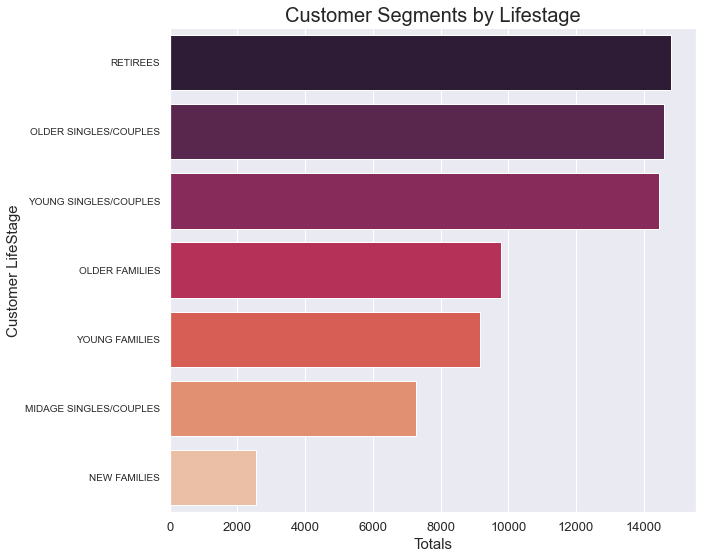

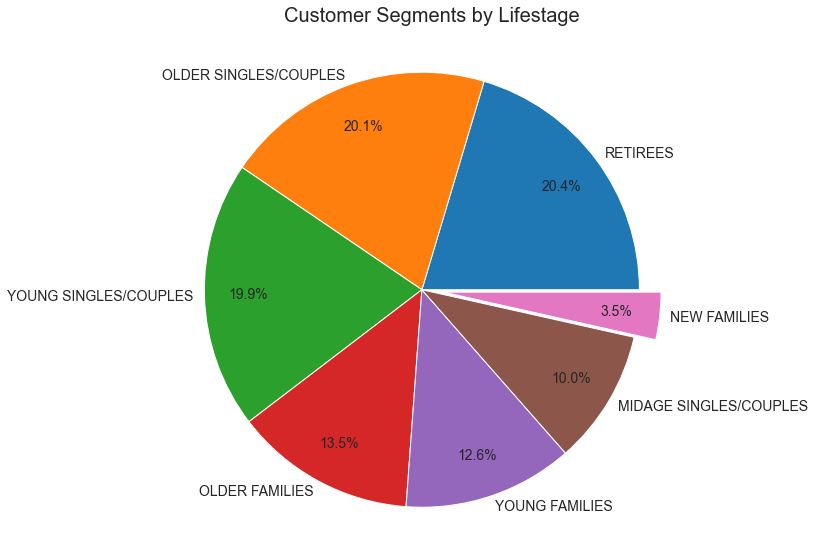

In [43]:
# Make a DataFrame
lifestage = pd.DataFrame.from_dict(dict(data2['LIFESTAGE'].value_counts()), orient = 'index', columns = ['Counts'])

# Show Distribution
plt.figure(figsize = (10,8))
ax = sns.set_style('darkgrid')
ax = sns.barplot(y = lifestage.index, x = lifestage['Counts'], palette = 'rocket')
ax.set_ylabel('Customer LifeStage', fontsize = 15)
ax.set_xlabel('Totals', fontsize = 15)
ax.axes.set_title('Customer Segments by Lifestage', fontsize = 20)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 10)
plt.tight_layout()

# Show Proportions
# Pie chart
pie, ax = plt.subplots(figsize = (10, 8))
labels = lifestage.index
plt.pie(x = lifestage['Counts'], autopct="%.1f%%", explode=(0, 0, 0, 0, 0, 0, .05), labels=labels, pctdistance=0.8, labeldistance = 1.05, textprops = {'fontsize': 14}, radius = 0.5)
plt.title("Customer Segments by Lifestage", fontsize=20)
ax.axis('square')
plt.tight_layout()

In [44]:
# Check Unique customers, grouping by lifestage
query = """
        SELECT LIFESTAGE, COUNT(DISTINCT(LYLTY_CARD_NBR)) AS 'UNIQUE_COUNTS'
        FROM data
        GROUP BY LIFESTAGE
        """
unique_lifestage_count = ps.sqldf(query, locals())
unique_lifestage_count

,LIFESTAGE,UNIQUE_COUNTS
0,MIDAGE SINGLES/COUPLES,7141
1,NEW FAMILIES,2492
2,OLDER FAMILIES,9630
3,OLDER SINGLES/COUPLES,14389
4,RETIREES,14555
5,YOUNG FAMILIES,9036
6,YOUNG SINGLES/COUPLES,14044


In [45]:
lifestage

,Counts
RETIREES,14805
OLDER SINGLES/COUPLES,14609
YOUNG SINGLES/COUPLES,14441
OLDER FAMILIES,9780
YOUNG FAMILIES,9178
MIDAGE SINGLES/COUPLES,7275
NEW FAMILIES,2549


OBSERVATIONS
- Business categorizes this segment into 7 classes.
- Majority of customers are either retirees or older/younger singles/couples, being 20.4%, 20.1% and 19.9% respectively, making up 60.4% of the population.

In [46]:
# Add average chip price per transaction
data['AVG_CHIP_PRICE'] = data['TOT_SALES']/data['PROD_QTY']
data

,real_date,STORE_NBR,TXN_ID,PROD_NAME,BRAND_NAME,PACKET_SIZE,PROD_QTY,TOT_SALES,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER,AVG_CHIP_PRICE
0,2018-07-01,9,8808,Smiths Thinly Cut Roast Chicken 175g,Smiths,175,2,6.0,9341,RETIREES,Budget,3.0
1,2018-07-01,86,84237,Red Rock Deli Sp Salt & Truffle 150G,RRD,150,2,5.4,86016,RETIREES,Mainstream,2.7
2,2018-07-01,129,132474,Smith Crinkle Cut Mac N Cheese 150g,Smiths,150,2,5.2,129046,OLDER SINGLES/COUPLES,Premium,2.6
3,2018-07-01,58,53145,Pringles Sthrn FriedChicken 134g,Pringles,134,2,7.4,58072,OLDER SINGLES/COUPLES,Premium,3.7
4,2018-07-01,97,97311,WW Crinkle Cut Chicken 175g,Woolworths,175,2,3.4,97164,OLDER FAMILIES,Premium,1.7
...,...,...,...,...,...,...,...,...,...,...,...,...
246735,2019-06-30,91,89519,Thins Chips Seasonedchicken 175g,Thins,175,2,6.6,91076,YOUNG SINGLES/COUPLES,Mainstream,3.3
246736,2019-06-30,84,83704,Doritos Corn Chips Nacho Cheese 170g,Doritos,170,2,8.8,84116,YOUNG SINGLES/COUPLES,Budget,4.4
246737,2019-06-30,24,20917,Smiths Crinkle Cut Chips Chs&Onion170g,Smiths,170,2,5.8,24115,YOUNG FAMILIES,Budget,2.9
246738,2019-06-30,199,198068,Doritos Corn Chips Nacho Cheese 170g,Doritos,170,2,8.8,199117,MIDAGE SINGLES/COUPLES,Mainstream,4.4


In [47]:
# make list of unique customers grouped by lifestage
unique_customers = [14555,14389,14044,9630,9036,7141,2492]
lifestage_analysis = lifestage
lifestage_analysis['UNIQUE_CUST'] = unique_customers
lifestage_analysis

,Counts,UNIQUE_CUST
RETIREES,14805,14555
OLDER SINGLES/COUPLES,14609,14389
YOUNG SINGLES/COUPLES,14441,14044
OLDER FAMILIES,9780,9630
YOUNG FAMILIES,9178,9036
MIDAGE SINGLES/COUPLES,7275,7141
NEW FAMILIES,2549,2492


In [48]:
# initialize lists
lifestage_sales_sum = []
lifestage_sales_avg = []
lifestage_avg_qty = []
lifestage_tot_qty = []
lifestage_avg_unit_price = []

# Get average spend and total sum of sales by lifestage
# Check average quantity and total quantity of chips bought per lifestage segment
for i in lifestage.index:
    subset = data[data['LIFESTAGE'] == i]
    lifestage_sales_sum.append(round(np.sum(subset['TOT_SALES']), 2))
    lifestage_sales_avg.append(round(np.mean(subset['TOT_SALES']), 2))
    lifestage_avg_qty.append(round(np.mean(subset['PROD_QTY']), 2))
    lifestage_tot_qty.append(np.sum(subset['PROD_QTY']))
    lifestage_avg_unit_price.append(round(np.mean(subset['AVG_CHIP_PRICE']), 2))
    


lifestage_analysis['AVG_SPEND'] = lifestage_sales_avg
lifestage_analysis['TOTAL_SPEND'] = lifestage_sales_sum
lifestage_analysis['AVG_QTY'] = lifestage_avg_qty
lifestage_analysis['TOT_QTY'] = lifestage_tot_qty
lifestage_analysis['AVG_CHIP_PRICE'] = lifestage_avg_unit_price
lifestage.reset_index(inplace=True)
lifestage_analysis.rename(columns = {'Counts':'TXN_COUNTS', 'index':'SEGMENT'}, inplace = True)
lifestage_analysis

,SEGMENT,TXN_COUNTS,UNIQUE_CUST,AVG_SPEND,TOTAL_SPEND,AVG_QTY,TOT_QTY,AVG_CHIP_PRICE
0,RETIREES,14805,14555,7.37,342381.90,1.89,87875,3.89
1,OLDER SINGLES/COUPLES,14609,14389,7.40,376013.95,1.91,97184,3.86
2,YOUNG SINGLES/COUPLES,14441,14044,7.18,243752.40,1.83,62298,3.89
3,OLDER FAMILIES,9780,9630,7.27,328519.90,1.95,87896,3.74
4,YOUNG FAMILIES,9178,9036,7.28,294627.90,1.94,78577,3.75
5,MIDAGE SINGLES/COUPLES,7275,7141,7.37,172523.80,1.90,44496,3.87
6,NEW FAMILIES,2549,2492,7.29,47347.95,1.86,12070,3.91


<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

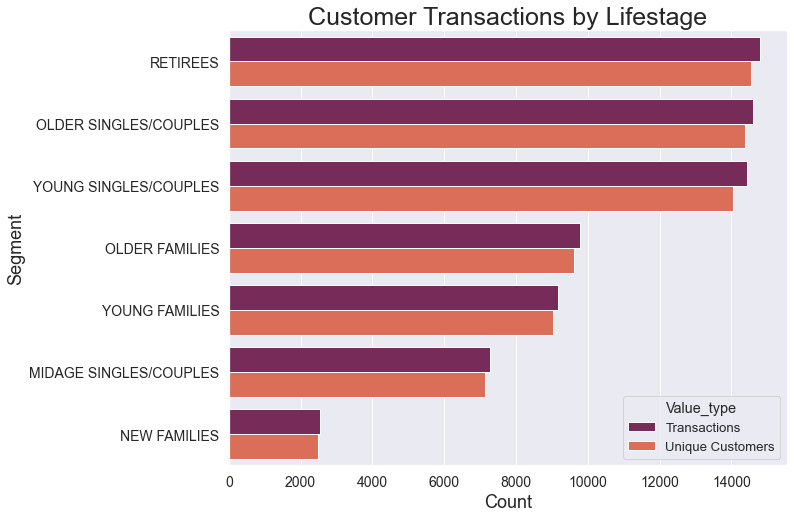

In [49]:
# Transaction analysis Dataframe
segments = []
for i in lifestage_analysis.SEGMENT:
    segments.append(i)

for i in lifestage_analysis.SEGMENT:
    segments.append(i)

counts = []
for i in lifestage_analysis['TXN_COUNTS']:
    counts.append(i)
for i in lifestage_analysis['UNIQUE_CUST']:
    counts.append(i)

types = ['Transactions','Transactions','Transactions','Transactions','Transactions','Transactions','Transactions', 
        'Unique Customers', 'Unique Customers','Unique Customers','Unique Customers','Unique Customers','Unique Customers','Unique Customers']

segments = pd.DataFrame(segments, columns = ['SEGMENT'])
segments['COUNTS'] = counts
segments['Value_type'] = types

# Make Visualization
plt.figure(figsize = (10,8))
ax = sns.barplot(y = 'SEGMENT', x = 'COUNTS', data = segments, hue = 'Value_type', palette= 'rocket')
ax.set_ylabel('Segment', fontsize = 18)
ax.set_xlabel('Count', fontsize = 18)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.tick_params(labelsize = 14)
plt.title('Customer Transactions by Lifestage', fontsize = 25)
plt.tight_layout

OBSERVATIONS:
- The number of transactions by each segment closely follows the population distribution of each segment.

In [50]:
lifestage_analysis

,SEGMENT,TXN_COUNTS,UNIQUE_CUST,AVG_SPEND,TOTAL_SPEND,AVG_QTY,TOT_QTY,AVG_CHIP_PRICE
0,RETIREES,14805,14555,7.37,342381.90,1.89,87875,3.89
1,OLDER SINGLES/COUPLES,14609,14389,7.40,376013.95,1.91,97184,3.86
2,YOUNG SINGLES/COUPLES,14441,14044,7.18,243752.40,1.83,62298,3.89
3,OLDER FAMILIES,9780,9630,7.27,328519.90,1.95,87896,3.74
4,YOUNG FAMILIES,9178,9036,7.28,294627.90,1.94,78577,3.75
5,MIDAGE SINGLES/COUPLES,7275,7141,7.37,172523.80,1.90,44496,3.87
6,NEW FAMILIES,2549,2492,7.29,47347.95,1.86,12070,3.91


Text(0.5, 1.0, 'Average Unit Price of Chips by Lifestage')

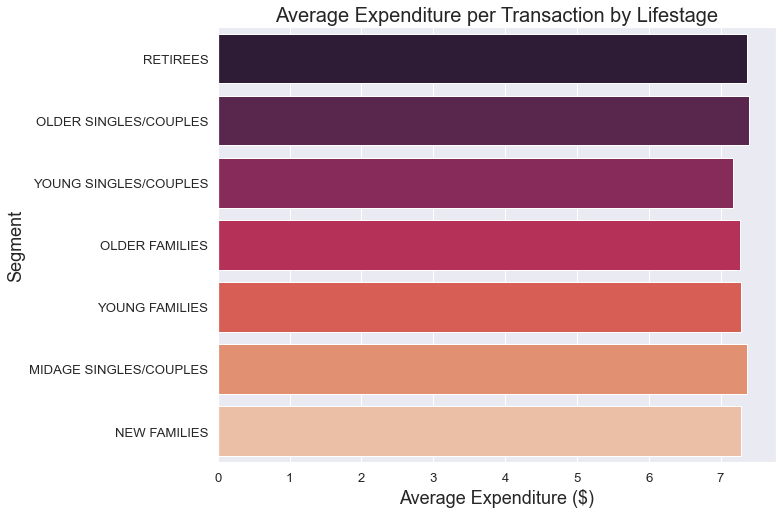

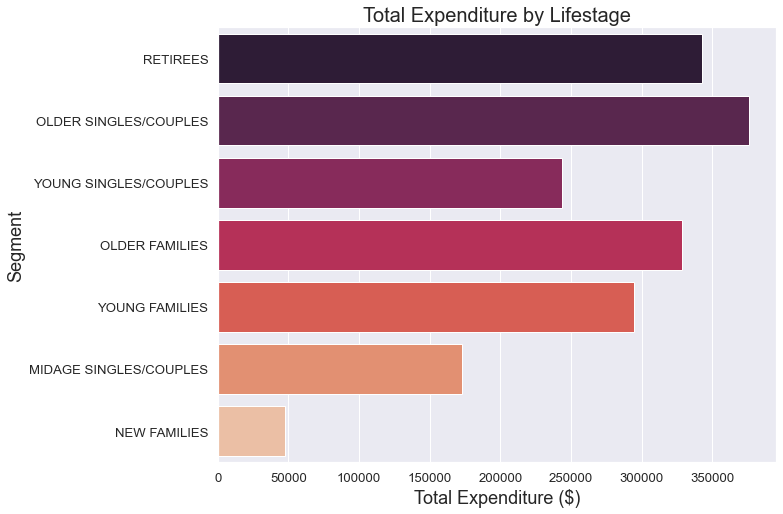

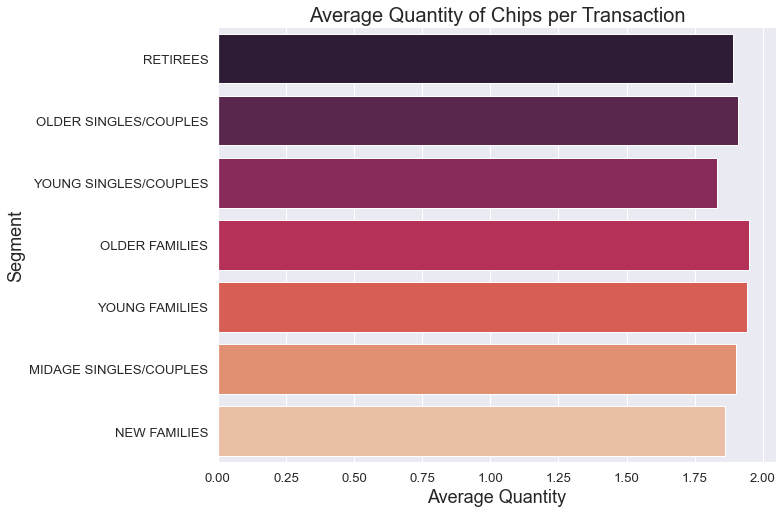

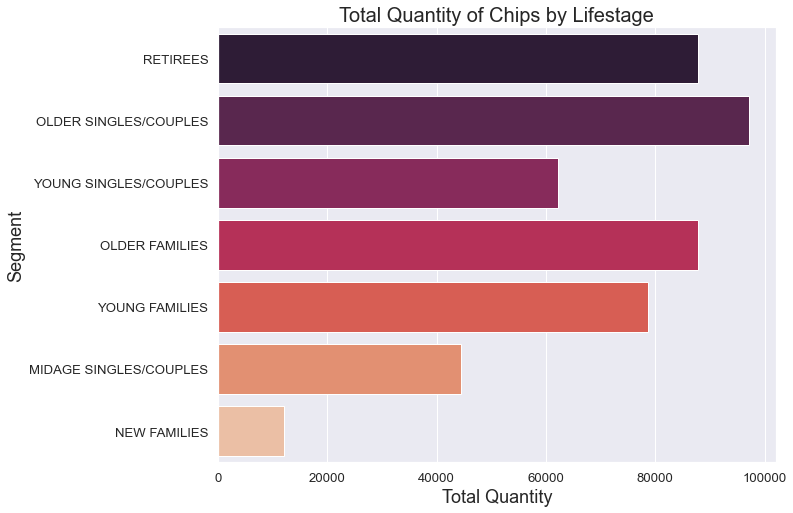

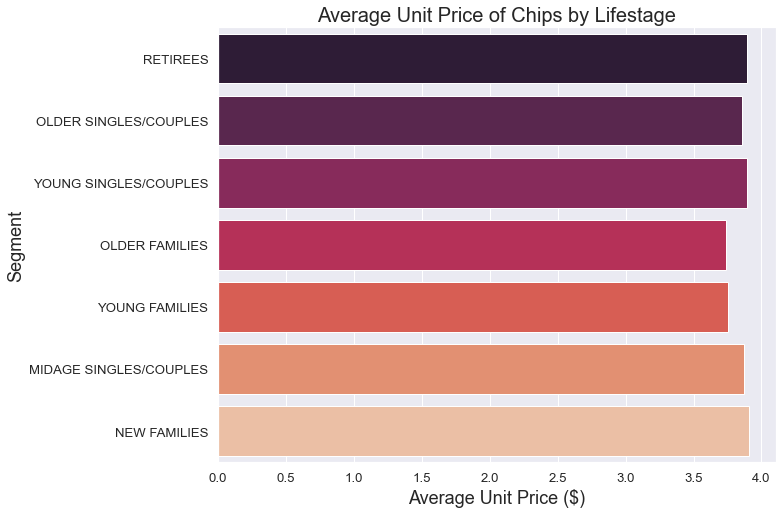

In [51]:
# QTY and Expenditure visualizations
# Average Expenditure
plt.figure(figsize = (10,8))
ax = sns.barplot(y = 'SEGMENT', x = 'AVG_SPEND', data = lifestage_analysis, palette = 'rocket')
ax.set_xlabel('Average Expenditure ($)', fontsize = 18)
ax.set_ylabel('Segment', fontsize = 18)
plt.title('Average Expenditure per Transaction by Lifestage', fontsize = 20)

# Total Expenditure
plt.figure(figsize = (10,8))
ax = sns.barplot(y = 'SEGMENT', x = 'TOTAL_SPEND', data = lifestage_analysis, palette = 'rocket')
ax.set_xlabel('Total Expenditure ($)', fontsize = 18)
ax.set_ylabel('Segment', fontsize = 18)
plt.title('Total Expenditure by Lifestage', fontsize = 20)

# Average QTY per transaction
plt.figure(figsize = (10,8))
ax = sns.barplot(y = 'SEGMENT', x = 'AVG_QTY', data = lifestage_analysis, palette = 'rocket')
ax.set_xlabel('Average Quantity', fontsize = 18)
ax.set_ylabel('Segment', fontsize = 18)
plt.title('Average Quantity of Chips per Transaction', fontsize = 20)

# Total QTY 
plt.figure(figsize = (10,8))
ax = sns.barplot(y = 'SEGMENT', x = 'TOT_QTY', data = lifestage_analysis, palette = 'rocket')
ax.set_xlabel('Total Quantity', fontsize = 18)
ax.set_ylabel('Segment', fontsize = 18)
plt.title('Total Quantity of Chips by Lifestage', fontsize = 20)

# Avg Chip/unit price 
plt.figure(figsize = (10,8))
ax = sns.barplot(y = 'SEGMENT', x = 'AVG_CHIP_PRICE', data = lifestage_analysis, palette = 'rocket')
ax.set_xlabel('Average Unit Price ($)', fontsize = 18)
ax.set_ylabel('Segment', fontsize = 18)
plt.title('Average Unit Price of Chips by Lifestage', fontsize = 20)

OBSERVATIONS:

EXPENDITURE
- All segments spend a very similar amount (+$7), with only slight deviation of 20c of each other.
- Older Singles/Couples spend the most on chips, followed by Retirees and Older Families.

QUANTITY
- All segments average between 1.75 to 2 chip packets per transaction.
- Older families have bought the most, with New Families the least.

AVERAGE UNIT PRICE
- The average price of each unit of chip sold for all subsets are all between $3.7 - $3.9



In [52]:
data['LIFESTAGE'].value_counts()

OLDER SINGLES/COUPLES     50792
RETIREES                  46431
OLDER FAMILIES            45158
YOUNG FAMILIES            40494
YOUNG SINGLES/COUPLES     33968
MIDAGE SINGLES/COUPLES    23398
NEW FAMILIES               6497
Name: LIFESTAGE, dtype: int64

-------------------------------------------------------------------
OLDER SINGLES/COUPLES
Kettle          8847
Smiths          6031
Doritos         5326
Pringles        5307
RRD             3042
Thins           2969
Infuzions       2962
Woolworths      2316
Tostitos        2039
Cobs            2036
Twisties        1949
GrnWves         1603
NCC             1466
Tyrrells        1340
Cheezels         966
CCs              851
Sunbites         584
Cheetos          580
Burger Rings     292
French Fries     286
Name: BRAND_NAME, dtype: int64


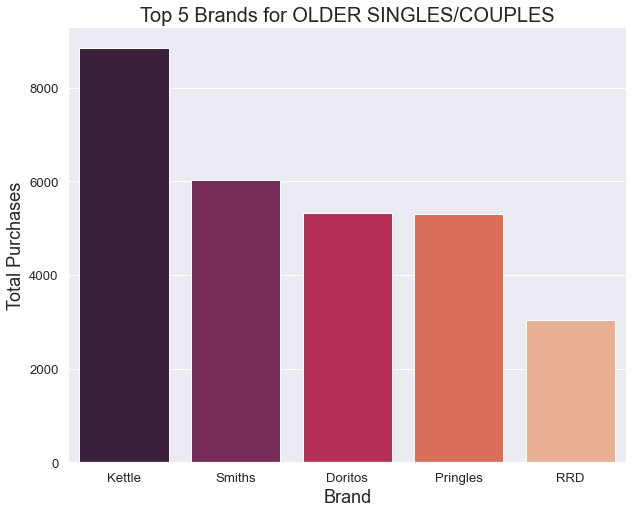

-------------------------------------------------------------------
RETIREES
Kettle          8194
Smiths          5374
Doritos         4987
Pringles        4951
Thins           2792
Infuzions       2719
RRD             2716
Woolworths      1945
Twisties        1890
Cobs            1884
Tostitos        1850
GrnWves         1466
NCC             1286
Tyrrells        1259
Cheezels         867
CCs              741
Sunbites         535
Cheetos          491
Burger Rings     256
French Fries     228
Name: BRAND_NAME, dtype: int64


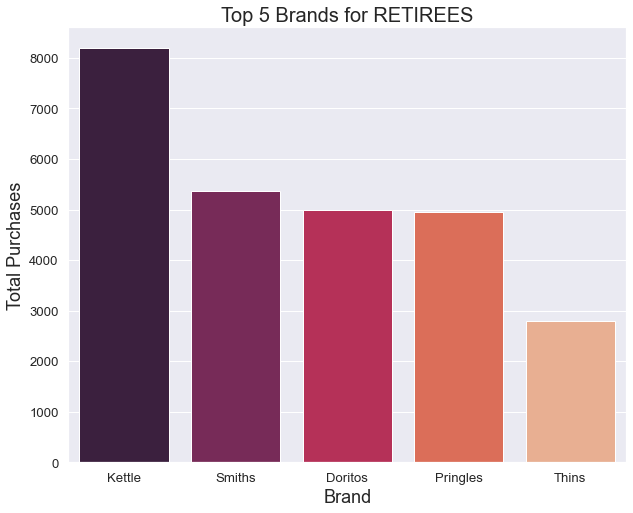

-------------------------------------------------------------------
OLDER FAMILIES
Kettle          6851
Smiths          6138
Pringles        4244
Doritos         4218
RRD             3593
Woolworths      2609
Infuzions       2496
Thins           2475
Twisties        1644
Cobs            1624
NCC             1571
Tostitos        1546
GrnWves         1429
Tyrrells        1093
CCs              941
Cheezels         813
Sunbites         622
Cheetos          615
Burger Rings     353
French Fries     283
Name: BRAND_NAME, dtype: int64


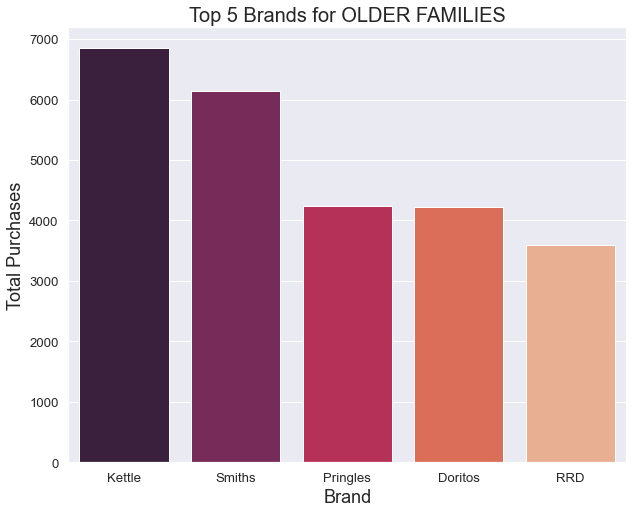

-------------------------------------------------------------------
YOUNG FAMILIES
Kettle          6277
Smiths          5399
Doritos         3894
Pringles        3829
RRD             3129
Infuzions       2215
Woolworths      2211
Thins           2186
Cobs            1504
Tostitos        1467
Twisties        1412
NCC             1367
GrnWves         1221
Tyrrells         997
CCs              898
Cheezels         771
Sunbites         596
Cheetos          550
Burger Rings     293
French Fries     278
Name: BRAND_NAME, dtype: int64


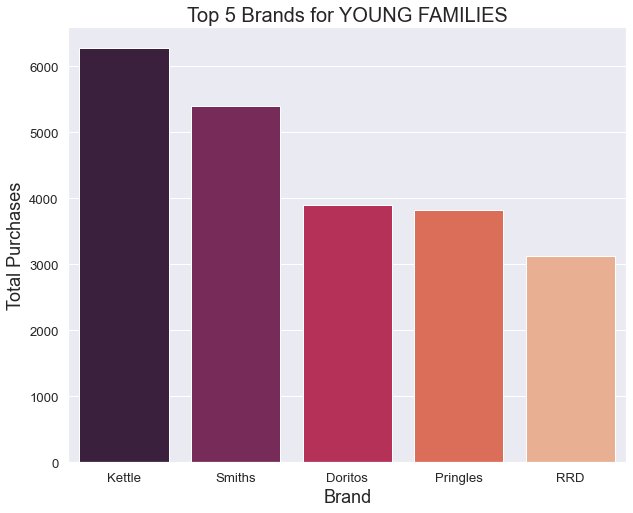

-------------------------------------------------------------------
YOUNG SINGLES/COUPLES
Kettle          5893
Smiths          3893
Pringles        3684
Doritos         3650
Infuzions       2013
RRD             2008
Thins           1959
Woolworths      1447
Cobs            1396
Twisties        1395
Tostitos        1368
GrnWves         1076
Tyrrells         955
NCC              927
Cheezels         613
CCs              594
Cheetos          364
Sunbites         361
French Fries     194
Burger Rings     178
Name: BRAND_NAME, dtype: int64


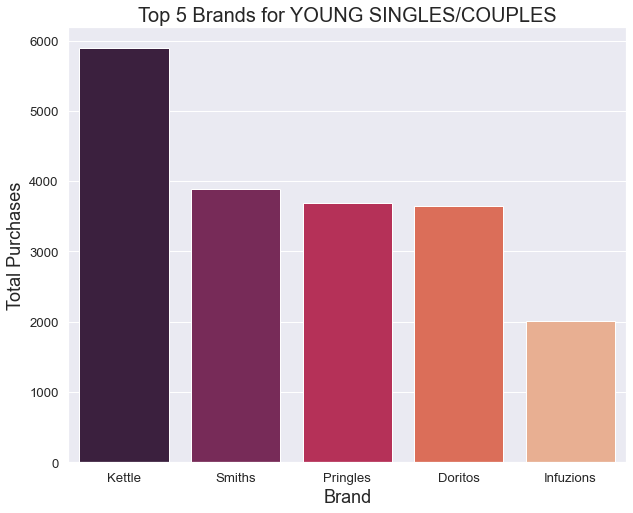

-------------------------------------------------------------------
MIDAGE SINGLES/COUPLES
Kettle          4055
Smiths          2790
Doritos         2423
Pringles        2389
RRD             1478
Infuzions       1403
Thins           1316
Woolworths      1032
Cobs             961
Twisties         931
Tostitos         924
GrnWves          732
NCC              694
Tyrrells         611
Cheezels         443
CCs              433
Cheetos          265
Sunbites         249
Burger Rings     152
French Fries     117
Name: BRAND_NAME, dtype: int64


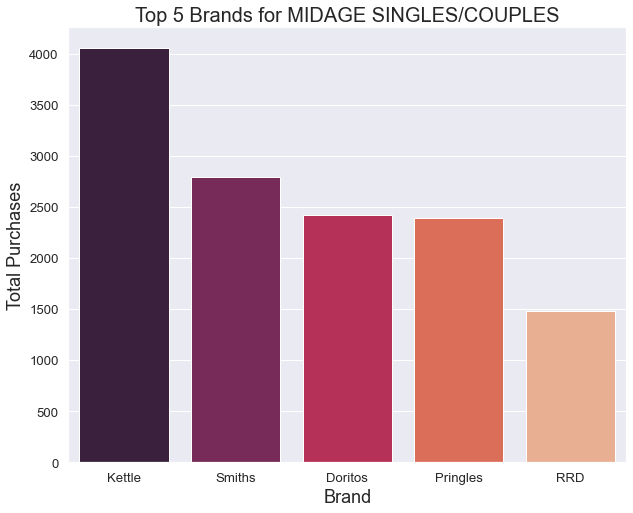

-------------------------------------------------------------------
NEW FAMILIES
Kettle          1171
Smiths           727
Doritos          726
Pringles         698
Infuzions        393
Thins            378
RRD              355
Cobs             288
Tostitos         277
Woolworths       276
Twisties         233
GrnWves          213
Tyrrells         187
NCC              158
Cheezels         129
CCs               93
Cheetos           62
Sunbites          61
Burger Rings      40
French Fries      32
Name: BRAND_NAME, dtype: int64


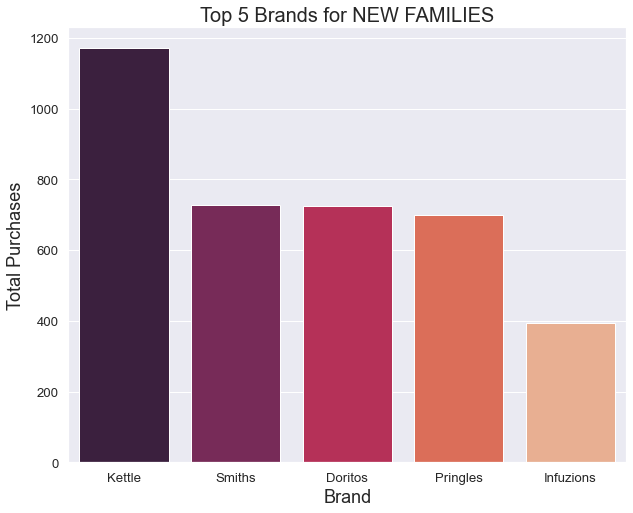

In [53]:
# Check favorite brands of customers by lifestage

lifestages = []
for i in dict(data['LIFESTAGE'].value_counts()):
    lifestages.append(i)

for subset in lifestages:
    dataframe = data[data['LIFESTAGE'] == subset]
    print('-------------------------------------------------------------------')
    print(subset)
    print(dataframe['BRAND_NAME'].value_counts())
    viz = pd.DataFrame.from_dict(dict(dataframe['BRAND_NAME'].value_counts()), orient = 'index', columns = ['count'])
    #Show visualization of top 5 brands
    values = viz['count'][:5]
    labels = viz.index[:5]
    plt.figure(figsize = (10,8))
    ax = sns.barplot(x = labels, y = values, palette = 'rocket')
    ax.set_xlabel('Brand', fontsize = 18)
    ax.set_ylabel('Total Purchases', fontsize = 18)
    plt.title(f'Top 5 Brands for {subset}', fontsize = 20)
    plt.show()


OBSERVATIONS:
- For all lifestage customer segments, the top 5 brands appear to be the same.
- The top 2 brands per segment are Kettle and Smiths, followed by either Doritos or Pringles.

# CUSTOMER PREMIUM ANALYSIS

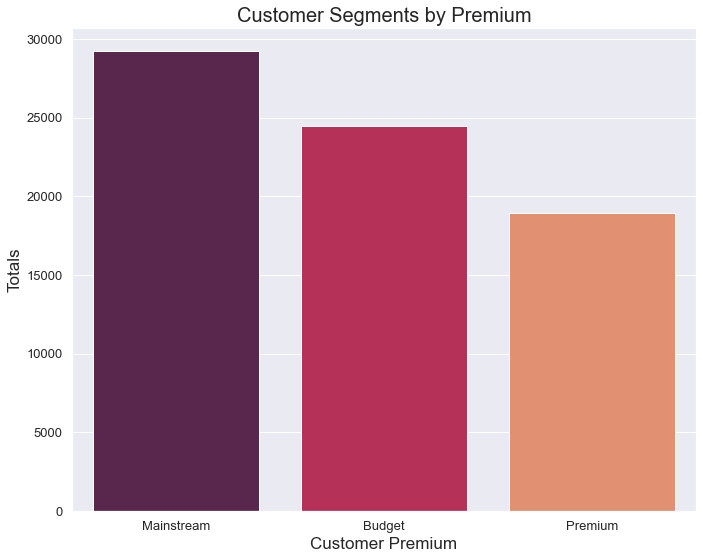

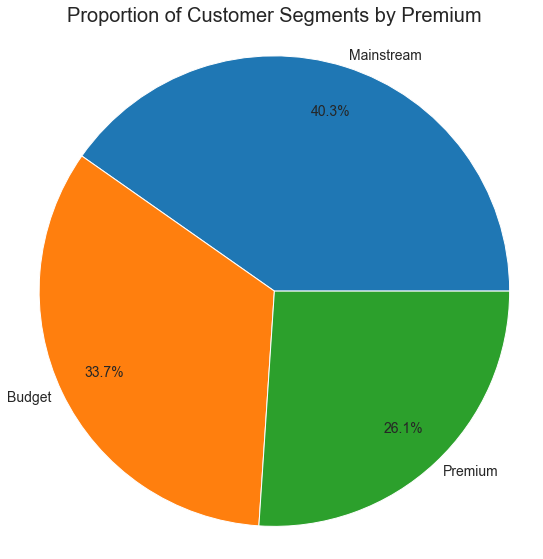

In [54]:
# Make a DataFrame
premium = pd.DataFrame.from_dict(dict(data2['PREMIUM_CUSTOMER'].value_counts()), orient = 'index', columns = ['Counts'])
premium
# Show Distribution
plt.figure(figsize = (10,8))
ax = sns.set_style('darkgrid')
ax = sns.barplot(x = premium.index, y = premium['Counts'], palette = 'rocket')
ax.set_xlabel('Customer Premium', fontsize = 17)
ax.set_ylabel('Totals', fontsize = 17)
ax.axes.set_title('Customer Segments by Premium', fontsize = 20)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.tight_layout()

# Show Proportions
# Pie chart
pie, ax = plt.subplots(figsize = (10, 8))
labels = premium.index
plt.pie(x = premium['Counts'], autopct="%.1f%%", labels=labels, pctdistance=0.8, labeldistance = 1.05, textprops = {'fontsize': 14}, radius = 0.5)
plt.title("Proportion of Customer Segments by Premium", fontsize=20)
ax.axis('square')
plt.tight_layout()

OBSERVATIONS:
- There are 3 segments for which describe a customer's premium: Budget, Mainstream and Premium.
- Majority of customer transactions are part of the Mainstream segment.

In [55]:
# Check unique customers, grouping by premium

query = """
        SELECT PREMIUM_CUSTOMER, COUNT(DISTINCT(LYLTY_CARD_NBR)) as 'UNIQUE_COUNTS'
        FROM data
        GROUP BY PREMIUM_CUSTOMER
        """
unique_premium_count = ps.sqldf(query,locals())
unique_premium_count

,PREMIUM_CUSTOMER,UNIQUE_COUNTS
0,Budget,24006
1,Mainstream,28734
2,Premium,18547


In [56]:
# Merge Columns
uc = [28734,24006,18547]
premium['unique_cust'] = uc
premium.rename(columns = {'Counts':'Transactions'}, inplace = True)
premium

,Transactions,unique_cust
Mainstream,29245,28734
Budget,24470,24006
Premium,18922,18547


In [57]:
# Perform sales summary for premiums

premium_sales_sum = []
premium_sales_avg = []
premium_avg_qty = []
premium_tot_qty = []
premium_avg_unit_price = []

# Get average spend and total sum
# Check average qty and total quantity of chips
# Check average unit price per segment

for i in premium.index:
    subset = data[data['PREMIUM_CUSTOMER'] == i]
    premium_sales_sum.append(round(np.sum(subset['TOT_SALES']), 2))
    premium_sales_avg.append(round(np.mean(subset['TOT_SALES']), 2))
    premium_avg_qty.append(round(np.mean(subset['PROD_QTY']), 2))
    premium_tot_qty.append(round(np.sum(subset['PROD_QTY'])))
    premium_avg_unit_price.append(round(np.mean(subset['AVG_CHIP_PRICE']), 2))

# Make columns in premium df
premium['AVG_SPEND'] = premium_sales_avg
premium['TOT_SPEND'] = premium_sales_sum
premium['AVG_QTY'] = premium_avg_qty
premium['TOT_QTY'] = premium_tot_qty
premium['AVG_CHIP_PRICE'] = premium_avg_unit_price
premium.reset_index(inplace=True)
premium.rename(columns = {'index':'Segment'}, inplace = True)
premium

,Segment,Transactions,unique_cust,AVG_SPEND,TOT_SPEND,AVG_QTY,TOT_QTY,AVG_CHIP_PRICE
0,Mainstream,29245,28734,7.37,700859.70,1.90,180779,3.87
1,Budget,24470,24006,7.28,631402.65,1.91,165772,3.80
2,Premium,18922,18547,7.28,472905.45,1.91,123845,3.81


<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

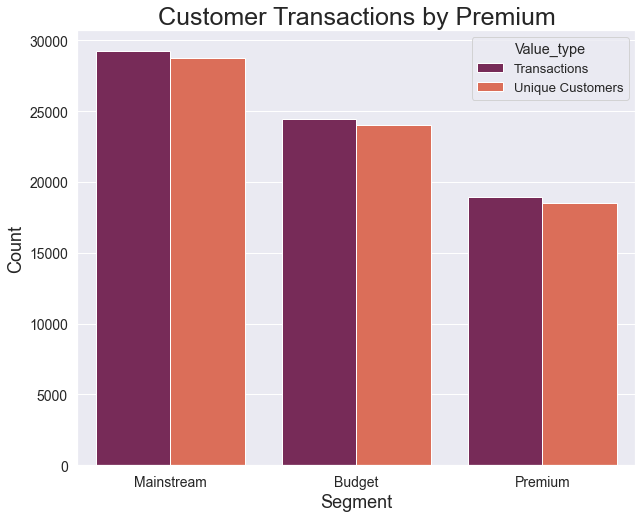

In [58]:
# Transaction analysis dataframe

segments = []
for i in premium.Segment:
    segments.append(i)
for i in premium.Segment:
    segments.append(i)

counts = []
for i in premium.Transactions:
    counts.append(i)
for i in premium.unique_cust:
    counts.append(i)

types = ['Transactions', 'Transactions', 'Transactions',
        'Unique Customers', 'Unique Customers', 'Unique Customers']

segments = pd.DataFrame(segments, columns = ['Segment'])
segments['Counts'] = counts
segments['Value_type'] = types

# Make viz
plt.figure(figsize = (10,8))
ax = sns.barplot(x = 'Segment', y = 'Counts', data = segments, hue = 'Value_type', palette= 'rocket')
ax.set_xlabel('Segment', fontsize = 18)
ax.set_ylabel('Count', fontsize = 18)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.tick_params(labelsize = 14)
plt.title('Customer Transactions by Premium', fontsize = 25)
plt.tight_layout


OBSERVATIONS:
- The number of transactions by each segment closely follows the populatio distribution of each segment.

In [59]:
premium

,Segment,Transactions,unique_cust,AVG_SPEND,TOT_SPEND,AVG_QTY,TOT_QTY,AVG_CHIP_PRICE
0,Mainstream,29245,28734,7.37,700859.70,1.90,180779,3.87
1,Budget,24470,24006,7.28,631402.65,1.91,165772,3.80
2,Premium,18922,18547,7.28,472905.45,1.91,123845,3.81


Text(0.5, 1.0, 'Average Unit Price of Chips by Premium')

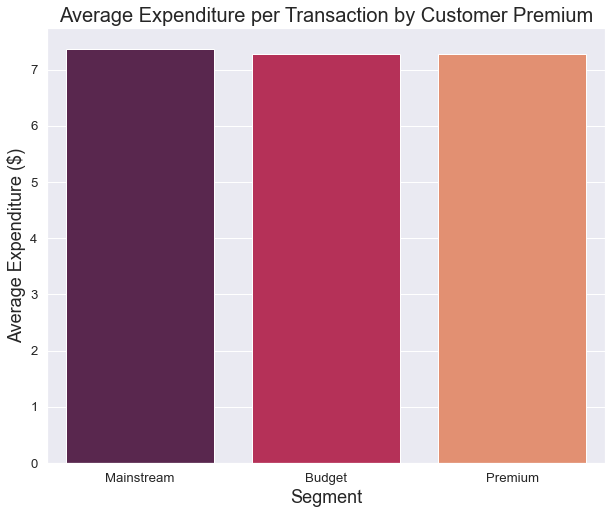

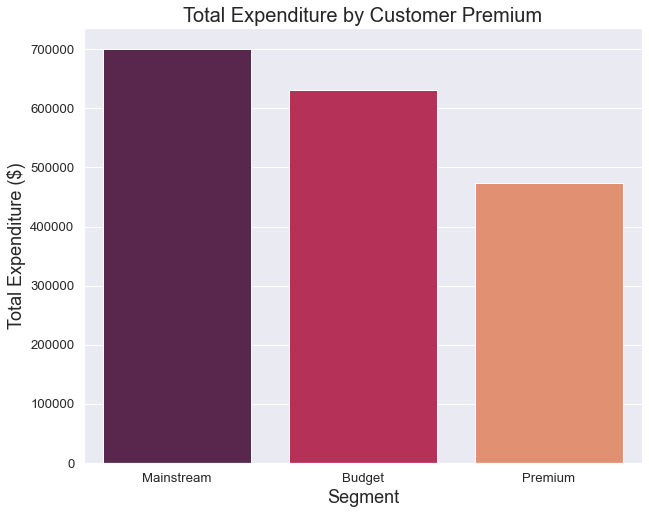

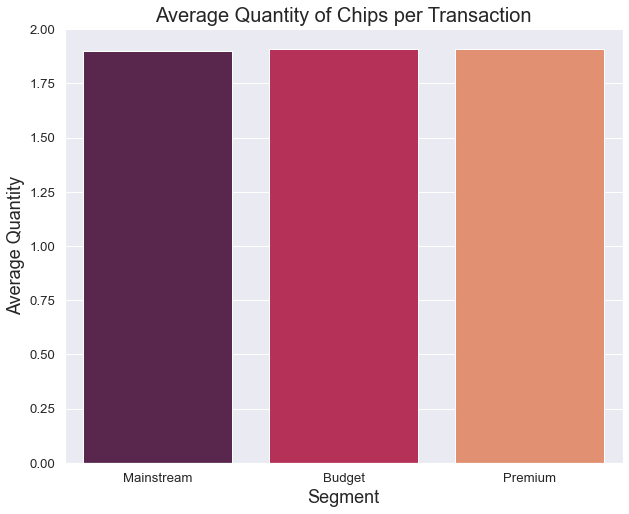

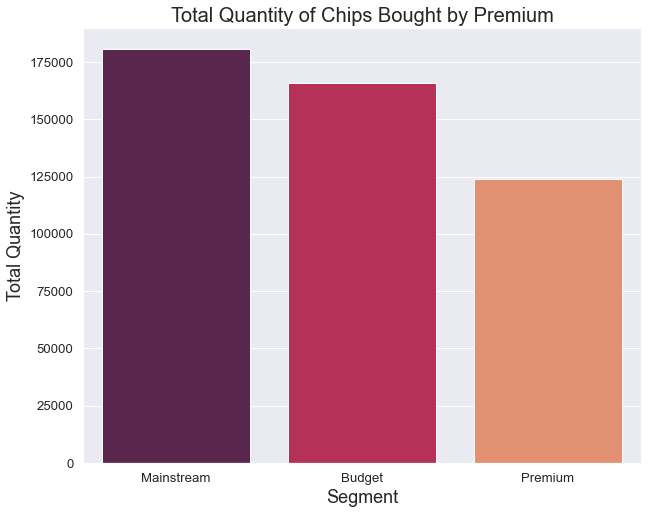

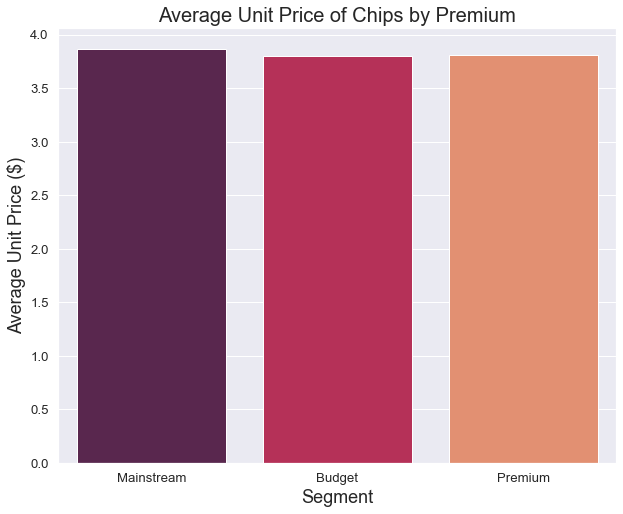

In [60]:
# QTY and Expenditure visualizations
# Average Expenditure
plt.figure(figsize = (10,8))
ax = sns.barplot(x = 'Segment', y = 'AVG_SPEND', data = premium, palette = 'rocket')
ax.set_ylabel('Average Expenditure ($)', fontsize = 18)
ax.set_xlabel('Segment', fontsize = 18)
plt.title('Average Expenditure per Transaction by Customer Premium', fontsize = 20)

# Total Expenditure
plt.figure(figsize = (10,8))
ax = sns.barplot(x = 'Segment', y = 'TOT_SPEND', data = premium, palette = 'rocket')
ax.set_ylabel('Total Expenditure ($)', fontsize = 18)
ax.set_xlabel('Segment', fontsize = 18)
plt.title('Total Expenditure by Customer Premium', fontsize = 20)

# Average QTY per transaction
plt.figure(figsize = (10,8))
ax = sns.barplot(x = 'Segment', y = 'AVG_QTY', data = premium, palette = 'rocket')
ax.set_ylabel('Average Quantity', fontsize = 18)
ax.set_xlabel('Segment', fontsize = 18)
plt.title('Average Quantity of Chips per Transaction', fontsize = 20)

# Total QTY 
plt.figure(figsize = (10,8))
ax = sns.barplot(x = 'Segment', y = 'TOT_QTY', data = premium, palette = 'rocket')
ax.set_ylabel('Total Quantity', fontsize = 18)
ax.set_xlabel('Segment', fontsize = 18)
plt.title('Total Quantity of Chips Bought by Premium', fontsize = 20)

# Avg Chip/unit price 
plt.figure(figsize = (10,8))
ax = sns.barplot(x = 'Segment', y = 'AVG_CHIP_PRICE', data = premium, palette = 'rocket')
ax.set_ylabel('Average Unit Price ($)', fontsize = 18)
ax.set_xlabel('Segment', fontsize = 18)
plt.title('Average Unit Price of Chips by Premium', fontsize = 20)

-------------------------------------------------------------------
Mainstream
Kettle          16423
Smiths          11300
Doritos         10114
Pringles         9903
RRD              5924
Infuzions        5550
Thins            5436
Woolworths       4130
Cobs             3889
Twisties         3785
Tostitos         3737
GrnWves          3037
NCC              2657
Tyrrells         2583
Cheezels         1735
CCs              1631
Cheetos          1111
Sunbites         1042
Burger Rings      548
French Fries      507
Name: BRAND_NAME, dtype: int64


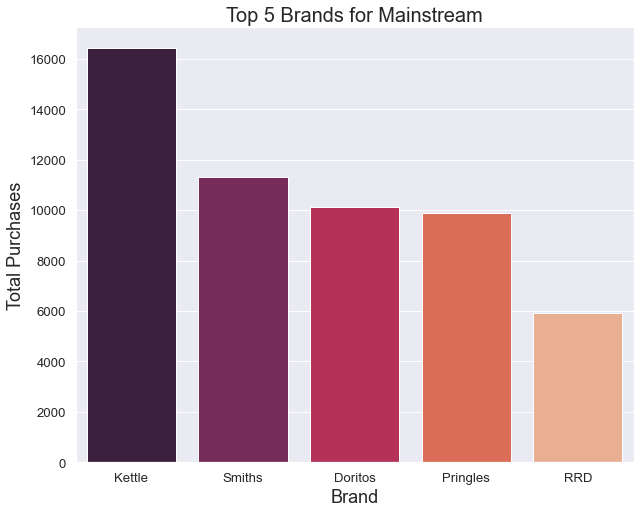

-------------------------------------------------------------------
Budget
Kettle          14154
Smiths          11008
Doritos          8718
Pringles         8620
RRD              5970
Thins            4931
Infuzions        4922
Woolworths       4444
Cobs             3274
Tostitos         3236
Twisties         3229
NCC              2785
GrnWves          2656
Tyrrells         2195
CCs              1679
Cheezels         1625
Sunbites         1146
Cheetos          1051
Burger Rings      579
French Fries      539
Name: BRAND_NAME, dtype: int64


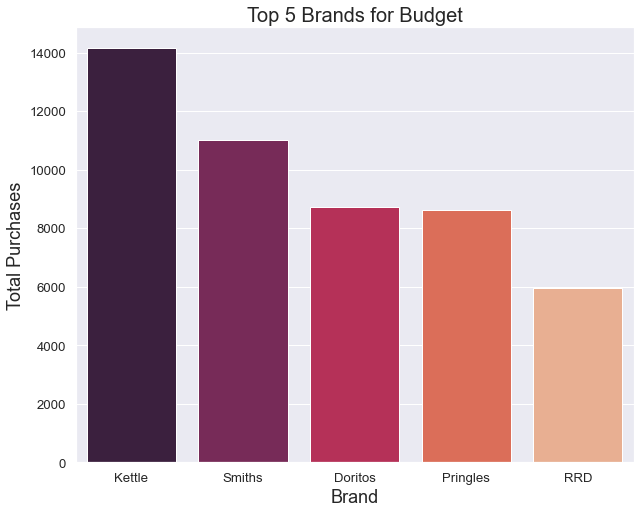

-------------------------------------------------------------------
Premium
Kettle          10711
Smiths           8044
Pringles         6579
Doritos          6392
RRD              4427
Infuzions        3729
Thins            3708
Woolworths       3262
Cobs             2530
Tostitos         2498
Twisties         2440
GrnWves          2047
NCC              2027
Tyrrells         1664
Cheezels         1242
CCs              1241
Sunbites          820
Cheetos           765
Burger Rings      437
French Fries      372
Name: BRAND_NAME, dtype: int64


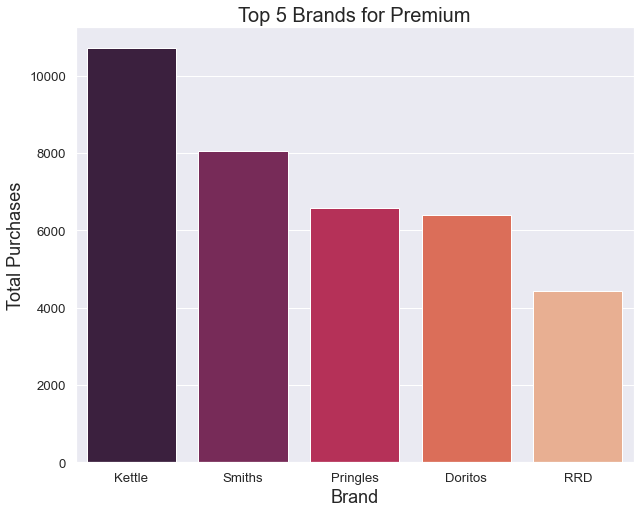

In [61]:
# Check favorite brands of customers by their premium

premiums = []
for i in dict(data['PREMIUM_CUSTOMER'].value_counts()):
    premiums.append(i)

for subset in premiums:
    dataframe = data[data['PREMIUM_CUSTOMER'] == subset]
    print('-------------------------------------------------------------------')
    print(subset)
    print(dataframe['BRAND_NAME'].value_counts())
    viz = pd.DataFrame.from_dict(dict(dataframe['BRAND_NAME'].value_counts()), orient = 'index', columns = ['count'])
    #Show visualization of top 5 brands
    values = viz['count'][:5]
    labels = viz.index[:5]
    plt.figure(figsize = (10,8))
    ax = sns.barplot(x = labels, y = values, palette = 'rocket')
    ax.set_xlabel('Brand', fontsize = 18)
    ax.set_ylabel('Total Purchases', fontsize = 18)
    plt.title(f'Top 5 Brands for {subset}', fontsize = 20)
    plt.show()


OBSERVATIONS:
- For all customer premium segments, the top 5 brands are all homogeneous, including order.
- The only observable difference is slight variation between ranks 3 & 4 (doritos & pringles), and 5 & 6 (rrd and infuzions).

# Check Proportion of lifestage segments within premiums

In [62]:
data

,real_date,STORE_NBR,TXN_ID,PROD_NAME,BRAND_NAME,PACKET_SIZE,PROD_QTY,TOT_SALES,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER,AVG_CHIP_PRICE
0,2018-07-01,9,8808,Smiths Thinly Cut Roast Chicken 175g,Smiths,175,2,6.0,9341,RETIREES,Budget,3.0
1,2018-07-01,86,84237,Red Rock Deli Sp Salt & Truffle 150G,RRD,150,2,5.4,86016,RETIREES,Mainstream,2.7
2,2018-07-01,129,132474,Smith Crinkle Cut Mac N Cheese 150g,Smiths,150,2,5.2,129046,OLDER SINGLES/COUPLES,Premium,2.6
3,2018-07-01,58,53145,Pringles Sthrn FriedChicken 134g,Pringles,134,2,7.4,58072,OLDER SINGLES/COUPLES,Premium,3.7
4,2018-07-01,97,97311,WW Crinkle Cut Chicken 175g,Woolworths,175,2,3.4,97164,OLDER FAMILIES,Premium,1.7
...,...,...,...,...,...,...,...,...,...,...,...,...
246735,2019-06-30,91,89519,Thins Chips Seasonedchicken 175g,Thins,175,2,6.6,91076,YOUNG SINGLES/COUPLES,Mainstream,3.3
246736,2019-06-30,84,83704,Doritos Corn Chips Nacho Cheese 170g,Doritos,170,2,8.8,84116,YOUNG SINGLES/COUPLES,Budget,4.4
246737,2019-06-30,24,20917,Smiths Crinkle Cut Chips Chs&Onion170g,Smiths,170,2,5.8,24115,YOUNG FAMILIES,Budget,2.9
246738,2019-06-30,199,198068,Doritos Corn Chips Nacho Cheese 170g,Doritos,170,2,8.8,199117,MIDAGE SINGLES/COUPLES,Mainstream,4.4


------------------------------
RETIREES
            Count
Mainstream  19970
Budget      14225
Premium     12236


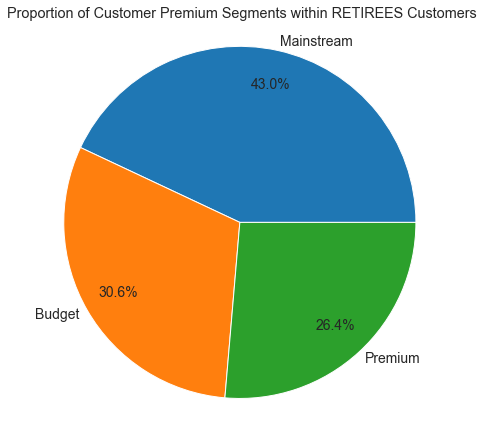

------------------------------
OLDER SINGLES/COUPLES
            Count
Budget      17172
Mainstream  17060
Premium     16560


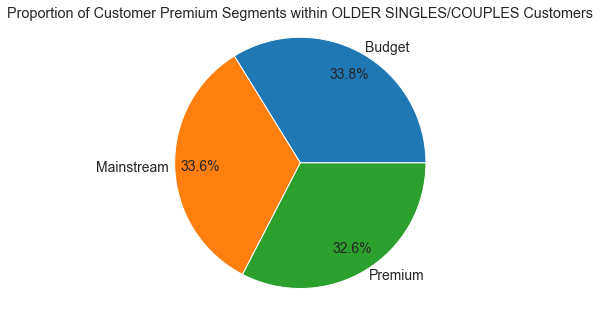

------------------------------
YOUNG SINGLES/COUPLES
            Count
Mainstream  19544
Budget       8572
Premium      5852


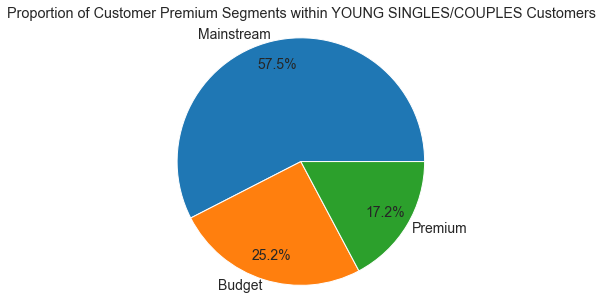

------------------------------
OLDER FAMILIES
            Count
Budget      21514
Mainstream  13241
Premium     10403


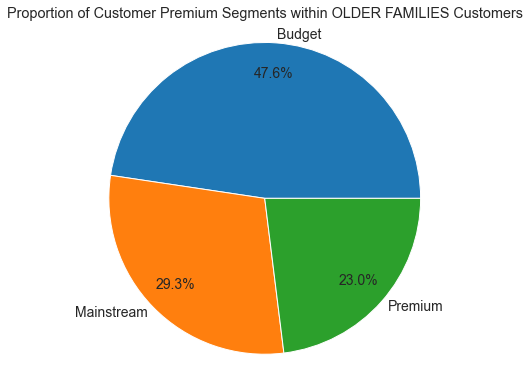

------------------------------
YOUNG FAMILIES
            Count
Budget      17763
Mainstream  11947
Premium     10784


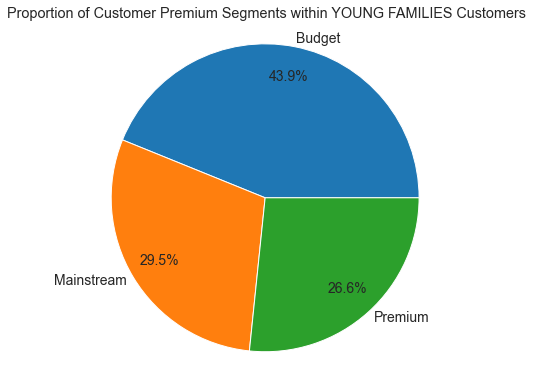

------------------------------
MIDAGE SINGLES/COUPLES
            Count
Mainstream  11095
Premium      7612
Budget       4691


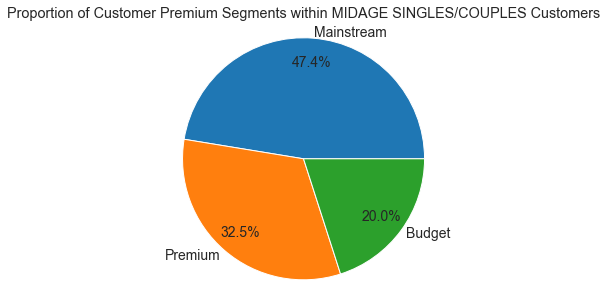

------------------------------
NEW FAMILIES
            Count
Budget       2824
Mainstream   2185
Premium      1488


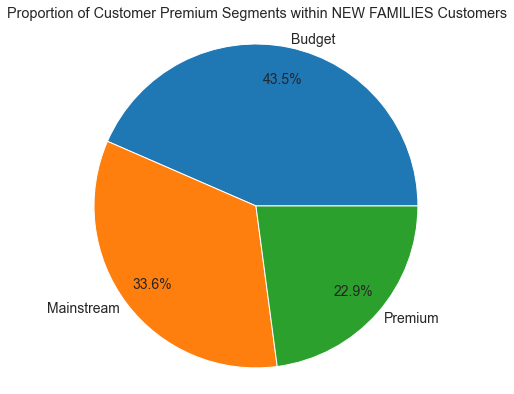

In [63]:
segments = ['RETIREES', 'OLDER SINGLES/COUPLES', 'YOUNG SINGLES/COUPLES', 'OLDER FAMILIES', 'YOUNG FAMILIES', 'MIDAGE SINGLES/COUPLES', 'NEW FAMILIES']

for i in segments:
    df = data[data['LIFESTAGE'] == i]
    dist = pd.DataFrame.from_dict(dict(df['PREMIUM_CUSTOMER'].value_counts()), orient = 'index', columns = ['Count'])
    print('------------------------------')
    print(i)
    print(dist)
    # Pie chart
    pie, ax = plt.subplots(figsize = (7,7))
    labels = dist.index
    plt.pie(x = dist['Count'], autopct = "%.1f%%", labels = labels, pctdistance = 0.8, labeldistance = 1.05, textprops = {'fontsize':14}, radius = 0.5)
    plt.title(f'Proportion of Customer Premium Segments within {i} Customers')
    ax.axis('square')
    plt.tight_layout()
    plt.show()

------------------------------
Budget
                        Count
OLDER FAMILIES          21514
YOUNG FAMILIES          17763
OLDER SINGLES/COUPLES   17172
RETIREES                14225
YOUNG SINGLES/COUPLES    8572
MIDAGE SINGLES/COUPLES   4691
NEW FAMILIES             2824


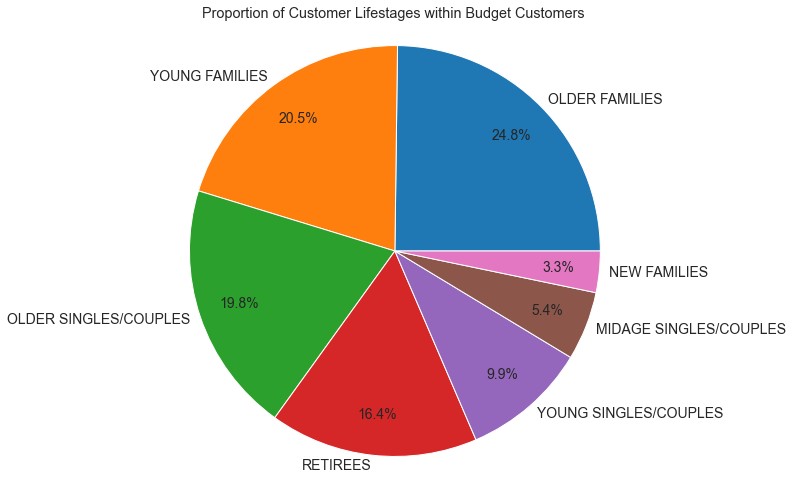

------------------------------
Mainstream
                        Count
RETIREES                19970
YOUNG SINGLES/COUPLES   19544
OLDER SINGLES/COUPLES   17060
OLDER FAMILIES          13241
YOUNG FAMILIES          11947
MIDAGE SINGLES/COUPLES  11095
NEW FAMILIES             2185


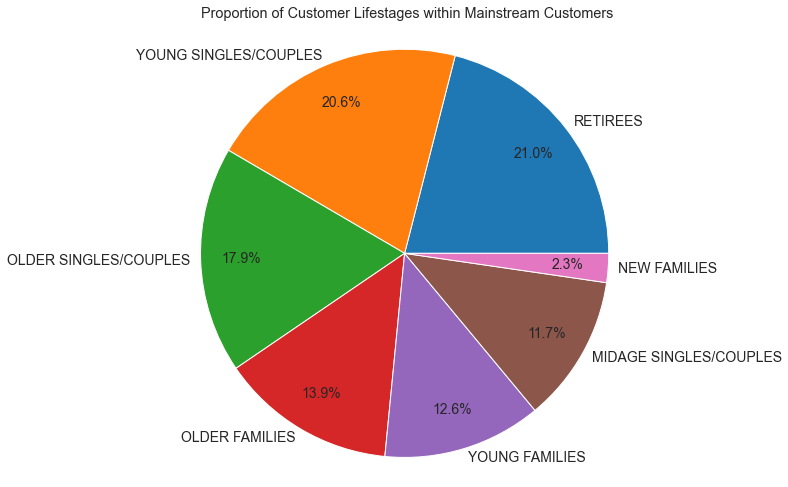

------------------------------
Premium
                        Count
OLDER SINGLES/COUPLES   16560
RETIREES                12236
YOUNG FAMILIES          10784
OLDER FAMILIES          10403
MIDAGE SINGLES/COUPLES   7612
YOUNG SINGLES/COUPLES    5852
NEW FAMILIES             1488


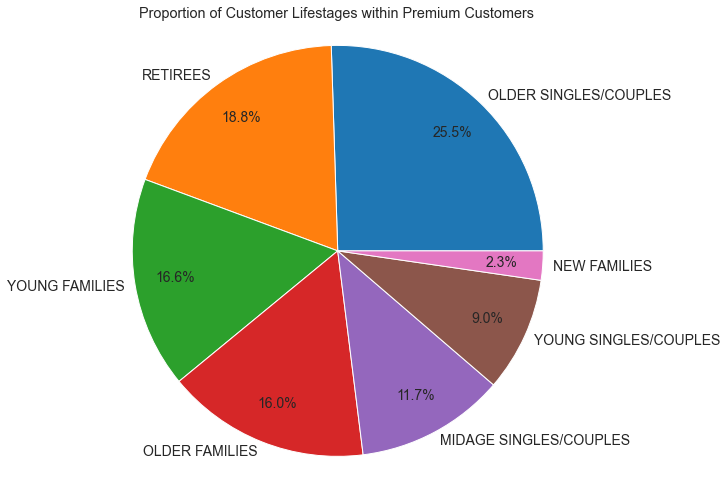

In [64]:
segments = ['Budget', 'Mainstream', 'Premium']

for i in segments:
    df = data[data['PREMIUM_CUSTOMER'] == i]
    dist = pd.DataFrame.from_dict(dict(df['LIFESTAGE'].value_counts()), orient = 'index', columns = ['Count'])
    print('------------------------------')
    print(i)
    print(dist)
    # Pie chart
    pie, ax = plt.subplots(figsize = (12,7))
    labels = dist.index
    plt.pie(x = dist['Count'], autopct = "%.1f%%", labels = labels, pctdistance = 0.8, labeldistance = 1.05, textprops = {'fontsize':14}, radius = 0.5)
    plt.title(f'Proportion of Customer Lifestages within {i} Customers')
    ax.axis('square')
    plt.tight_layout()
    plt.show()

# Average Unit Price by Totals

In [65]:
# Check average unit price via total sales / total qty and NOT by transaction
lifestage

,SEGMENT,TXN_COUNTS,UNIQUE_CUST,AVG_SPEND,TOTAL_SPEND,AVG_QTY,TOT_QTY,AVG_CHIP_PRICE
0,RETIREES,14805,14555,7.37,342381.90,1.89,87875,3.89
1,OLDER SINGLES/COUPLES,14609,14389,7.40,376013.95,1.91,97184,3.86
2,YOUNG SINGLES/COUPLES,14441,14044,7.18,243752.40,1.83,62298,3.89
3,OLDER FAMILIES,9780,9630,7.27,328519.90,1.95,87896,3.74
4,YOUNG FAMILIES,9178,9036,7.28,294627.90,1.94,78577,3.75
5,MIDAGE SINGLES/COUPLES,7275,7141,7.37,172523.80,1.90,44496,3.87
6,NEW FAMILIES,2549,2492,7.29,47347.95,1.86,12070,3.91


In [66]:
premium

,Segment,Transactions,unique_cust,AVG_SPEND,TOT_SPEND,AVG_QTY,TOT_QTY,AVG_CHIP_PRICE
0,Mainstream,29245,28734,7.37,700859.70,1.90,180779,3.87
1,Budget,24470,24006,7.28,631402.65,1.91,165772,3.80
2,Premium,18922,18547,7.28,472905.45,1.91,123845,3.81


In [67]:
# Check unit price per lifestage
lifestage['PER_UNIT_PRICE_TOTAL'] = lifestage['TOTAL_SPEND']/lifestage['TOT_QTY']
lifestage 

,SEGMENT,TXN_COUNTS,UNIQUE_CUST,AVG_SPEND,TOTAL_SPEND,AVG_QTY,TOT_QTY,AVG_CHIP_PRICE,PER_UNIT_PRICE_TOTAL
0,RETIREES,14805,14555,7.37,342381.90,1.89,87875,3.89,3.896238
1,OLDER SINGLES/COUPLES,14609,14389,7.40,376013.95,1.91,97184,3.86,3.869093
2,YOUNG SINGLES/COUPLES,14441,14044,7.18,243752.40,1.83,62298,3.89,3.912684
3,OLDER FAMILIES,9780,9630,7.27,328519.90,1.95,87896,3.74,3.737598
4,YOUNG FAMILIES,9178,9036,7.28,294627.90,1.94,78577,3.75,3.749544
5,MIDAGE SINGLES/COUPLES,7275,7141,7.37,172523.80,1.90,44496,3.87,3.877288
6,NEW FAMILIES,2549,2492,7.29,47347.95,1.86,12070,3.91,3.922780


Text(0.5, 1.0, 'Average Unit Price per Lifestage')

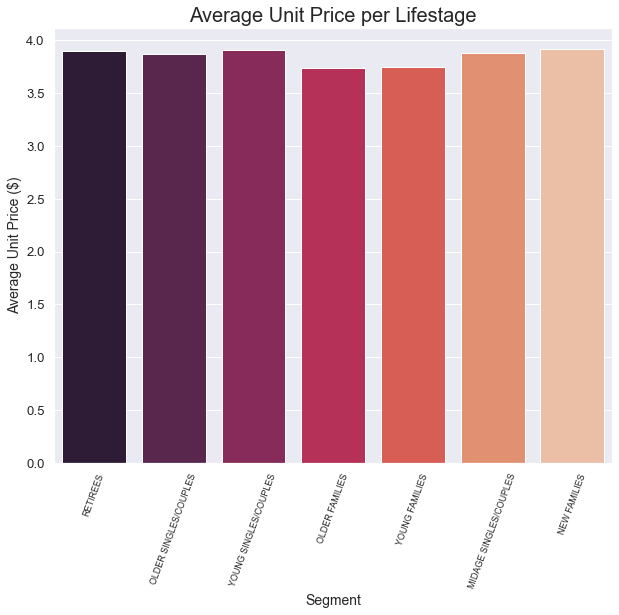

In [68]:
# plot unit price totals
plt.figure(figsize = (10,8))
ax = sns.barplot(x = 'SEGMENT', y = 'PER_UNIT_PRICE_TOTAL', data = lifestage, palette = 'rocket')
ax.set_ylabel('Average Unit Price ($)', fontsize = 14)
ax.set_xlabel('Segment', fontsize = 14)
plt.xticks(fontsize = 9, rotation = 70)
plt.title('Average Unit Price per Lifestage', fontsize = 20)


In [69]:
premium['PER_UNIT_PRICE_TOTAL'] = premium['TOT_SPEND']/premium['TOT_QTY']
premium

,Segment,Transactions,unique_cust,AVG_SPEND,TOT_SPEND,AVG_QTY,TOT_QTY,AVG_CHIP_PRICE,PER_UNIT_PRICE_TOTAL
0,Mainstream,29245,28734,7.37,700859.70,1.90,180779,3.87,3.876887
1,Budget,24470,24006,7.28,631402.65,1.91,165772,3.80,3.808862
2,Premium,18922,18547,7.28,472905.45,1.91,123845,3.81,3.818527


Text(0.5, 1.0, 'Average Unit Price per Customer Premium')

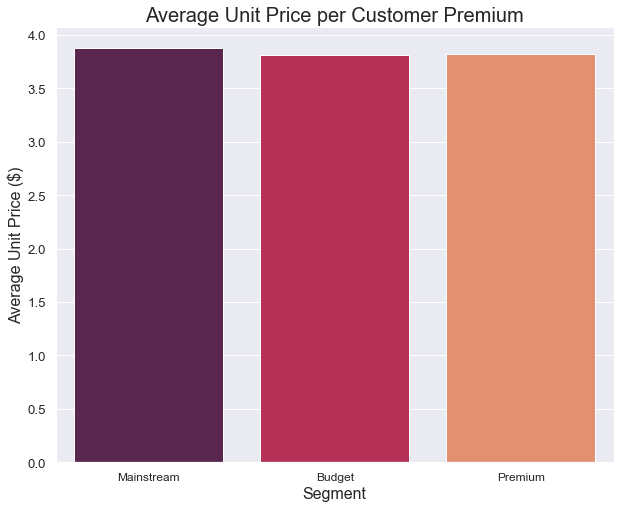

In [70]:
# plot unit price totals
plt.figure(figsize = (10,8))
ax = sns.barplot(x = 'Segment', y = 'PER_UNIT_PRICE_TOTAL', data = premium, palette = 'rocket')
ax.set_ylabel('Average Unit Price ($)', fontsize = 16)
ax.set_xlabel('Segment', fontsize = 16)
plt.xticks(fontsize = 12)
plt.title('Average Unit Price per Customer Premium', fontsize = 20)

OBSERVATIONS:

LIFESTAGE
- Younger singles/couples are more willing to spend on more premium ranges of snacks.

CUSTOMER PREMIUMS
- Mainstream customers are more willing to spend on more premium ranges of snacks.

Based on the data shown, young singles/couples who are registered as the mainstream premiums are willing to pay more per unit compared to other segments. Reasons for this could lie with a more health-oriented purchasing behaviour. This is further backed up by there being fewer purchases by premium middle aged and young singles/couples customers, compared to mainstream segments of the same kind.


- Must check if difference in unit price is statistically significant.

# T-Test of significance for difference in average unit price.

In [71]:
# Gather Segment data into sepeate df's

# Mainstream young/midage singles/couples
query = """
        SELECT *
        FROM data
        WHERE (LIFESTAGE = 'YOUNG SINGLES/COUPLES') OR 
        (LIFESTAGE = 'MIDAGE SINGLES/COUPLES')
        """
lifestage_df = ps.sqldf(query, locals())

query = """
        SELECT * 
        FROM lifestage_df
        WHERE (PREMIUM_CUSTOMER = 'Mainstream')
        """
mainstream_data = ps.sqldf(query, locals())

# Premium young/midage singles/couples
query = """
        SELECT * 
        FROM lifestage_df
        WHERE (PREMIUM_CUSTOMER = 'Premium') OR (PREMIUM_CUSTOMER = 'Budget')
        """
premium_budget_data = ps.sqldf(query, locals())


In [72]:
# Function for viz distribution
def plot_distribution(inp, subset):
    plt.figure(figsize = (13,8))
    ax = sns.distplot(inp)
    plt.axvline(np.mean(inp), color = 'k', linestyle = 'dashed', linewidth = 5)
    _, max_ = plt.ylim()
    plt.text(
        inp.mean() + inp.mean() / 10,
        max_ - max_ / 10,
        "Mean: {:.2f}".format(inp.mean())
    )
    plt.title(f'Distribution of Average Unit Price for {subset}', fontsize = 20)
    plt.xlabel('Average Unit Price ($)')
    return plt.figure

C:\Users\Joel\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Joel\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


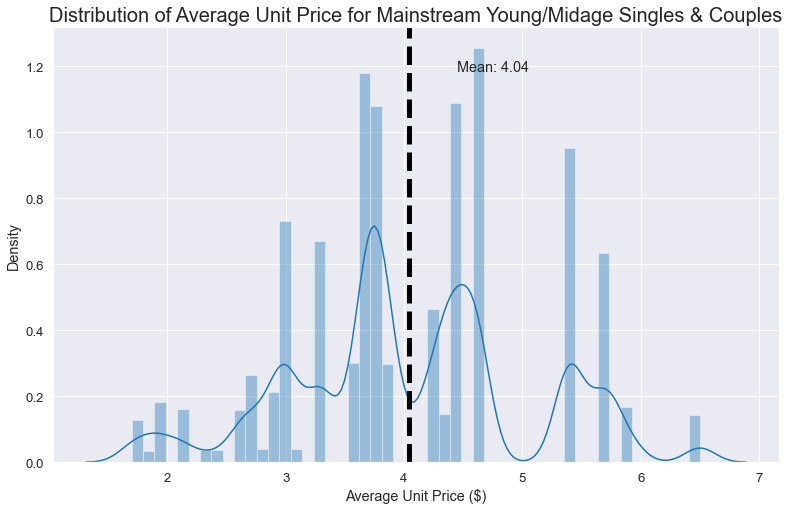

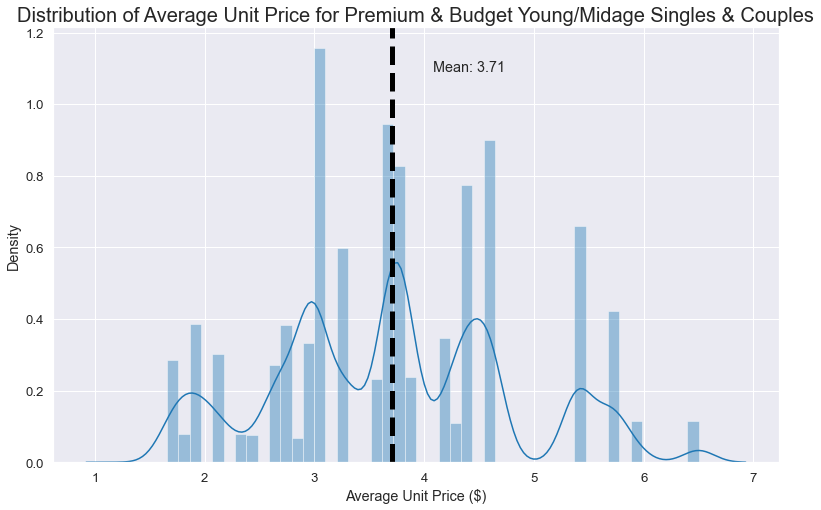

In [73]:
# Distributions of each segment's avg unit price
dataframes = [mainstream_data, premium_budget_data]
subset_names = ['Mainstream Young/Midage Singles & Couples',
                'Premium & Budget Young/Midage Singles & Couples']

for df, subset in zip(dataframes, subset_names):
    plot_distribution(df['AVG_CHIP_PRICE'], subset)

C:\Users\Joel\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Joel\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


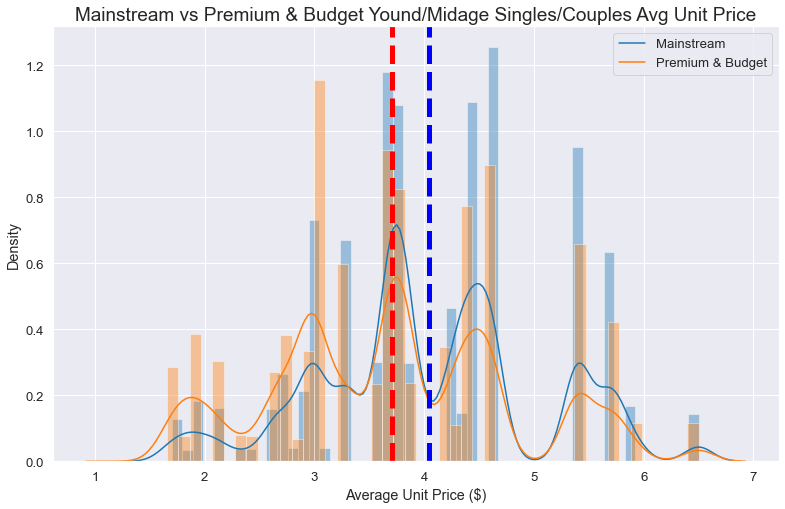

In [74]:
# Show Comparison distributions

#Mainstream vs Premium & Budget
plt.figure(figsize = (13,8))
ax1 = sns.distplot(mainstream_data['AVG_CHIP_PRICE'])
ax2 = sns.distplot(premium_budget_data['AVG_CHIP_PRICE'])
plt.axvline(np.mean(mainstream_data['AVG_CHIP_PRICE']), color = 'b', linestyle = 'dashed', linewidth = 5)
plt.axvline(np.mean(premium_budget_data['AVG_CHIP_PRICE']), color = 'red', linestyle = 'dashed', linewidth = 5)
plt.xlabel('Average Unit Price ($)')
plt.title('Mainstream vs Premium & Budget Yound/Midage Singles/Couples Avg Unit Price', fontsize = 19)
plt.legend(['Mainstream','Premium & Budget'])


In [75]:
# compare 2 groups func
def compare_2_groups(arr_1, arr_2, alpha, sample_size):
    stat, p = ttest_ind(arr_1, arr_2)
    print('Statistics = %.3f, p=%.3f' % (stat, p))
    if p > alpha:
        print('Same distribution (fail to reject H0)')
    else:
        print('Different distributions (reject H0)')

In [76]:
# Perform T-Test
sample_size = 200
mainstream_sampled = np.random.choice(mainstream_data['AVG_CHIP_PRICE'], sample_size)
premium_budget_sampled = np.random.choice(premium_budget_data['AVG_CHIP_PRICE'], sample_size)
compare_2_groups(mainstream_sampled, premium_budget_sampled, 0.05, sample_size)

Statistics = 4.283, p=0.000
Different distributions (reject H0)


OBSERVATIONS:
The t-test results in a p-value of 0.015, i.e. the unit price for mainstream, young and mid-age singles and couples are significantly higher than that of budget or premium yound and midage singles and couples.

# Further Insights for Segments

In [77]:
lifestage.sort_values(by = 'TOTAL_SPEND', ascending=False)

,SEGMENT,TXN_COUNTS,UNIQUE_CUST,AVG_SPEND,TOTAL_SPEND,AVG_QTY,TOT_QTY,AVG_CHIP_PRICE,PER_UNIT_PRICE_TOTAL
1,OLDER SINGLES/COUPLES,14609,14389,7.40,376013.95,1.91,97184,3.86,3.869093
0,RETIREES,14805,14555,7.37,342381.90,1.89,87875,3.89,3.896238
3,OLDER FAMILIES,9780,9630,7.27,328519.90,1.95,87896,3.74,3.737598
4,YOUNG FAMILIES,9178,9036,7.28,294627.90,1.94,78577,3.75,3.749544
2,YOUNG SINGLES/COUPLES,14441,14044,7.18,243752.40,1.83,62298,3.89,3.912684
5,MIDAGE SINGLES/COUPLES,7275,7141,7.37,172523.80,1.90,44496,3.87,3.877288
6,NEW FAMILIES,2549,2492,7.29,47347.95,1.86,12070,3.91,3.922780


In [78]:
premium.sort_values(by = 'TOT_SPEND', ascending=False)

,Segment,Transactions,unique_cust,AVG_SPEND,TOT_SPEND,AVG_QTY,TOT_QTY,AVG_CHIP_PRICE,PER_UNIT_PRICE_TOTAL
0,Mainstream,29245,28734,7.37,700859.70,1.90,180779,3.87,3.876887
1,Budget,24470,24006,7.28,631402.65,1.91,165772,3.80,3.808862
2,Premium,18922,18547,7.28,472905.45,1.91,123845,3.81,3.818527


In [124]:
seg_list = ['OLDER SINGLES/COUPLES', 'OLDER SINGLES/COUPLES', 'OLDER SINGLES/COUPLES',
           'RETIREES', 'RETIREES', 'RETIREES', 
           'OLDER FAMILIES', 'OLDER FAMILIES','OLDER FAMILIES',
           'YOUNG FAMILIES', 'YOUNG FAMILIES','YOUNG FAMILIES',
           'YOUNG SINGLES/COUPLES', 'YOUNG SINGLES/COUPLES', 'YOUNG SINGLES/COUPLES', 
           'MIDAGE SINGLES/COUPLES', 'MIDAGE SINGLES/COUPLES', 'MIDAGE SINGLES/COUPLES', 
           'NEW FAMILIES', 'NEW FAMILIES', 'NEW FAMILIES']

prem_list = ['Mainstream', 'Budget', 'Premium',
            'Mainstream', 'Budget', 'Premium',
            'Mainstream', 'Budget', 'Premium',
            'Mainstream', 'Budget', 'Premium',
            'Mainstream', 'Budget', 'Premium',
            'Mainstream', 'Budget', 'Premium',
            'Mainstream', 'Budget', 'Premium']

viz_df = pd.DataFrame(seg_list, columns = ['LIFESTAGE'])
viz_df['PREMIUM'] = prem_list

avg_sales_list = []
tot_sales_list = []
avg_qty_list = []
avg_unit_price_list = []
cust_count = []

for lifestage, premium in zip(viz_df['LIFESTAGE'], viz_df['PREMIUM']):
    x_df = data[(data['LIFESTAGE'] == lifestage) & (data['PREMIUM_CUSTOMER'] == premium)]
    avg_sales_list.append(np.mean(x_df['TOT_SALES']))
    tot_sales_list.append(np.sum(x_df['TOT_SALES']))
    avg_qty_list.append(np.mean(x_df['PROD_QTY']))
    avg_unit_price_list.append(np.mean(x_df['AVG_CHIP_PRICE']))
    cust_count.append(len(x_df))
    
    
    
viz_df['avg_sales'] = avg_sales_list
viz_df['tot_sales'] = tot_sales_list
viz_df['avg_qty'] = avg_qty_list
viz_df['avg_unit_price'] = avg_unit_price_list
viz_df['cust_count'] = cust_count
viz_df

,LIFESTAGE,PREMIUM,avg_sales,tot_sales,avg_qty,avg_unit_price,cust_count
0,OLDER SINGLES/COUPLES,Mainstream,7.306143,124642.80,1.911254,3.814555,17060
1,OLDER SINGLES/COUPLES,Budget,7.444305,127833.60,1.914920,3.882096,17172
2,OLDER SINGLES/COUPLES,Premium,7.459997,123537.55,1.913949,3.893182,16560
3,RETIREES,Mainstream,7.269352,145168.95,1.886680,3.844294,19970
4,RETIREES,Budget,7.445786,105916.30,1.893286,3.924404,14225
5,RETIREES,Premium,7.461315,91296.65,1.901438,3.920942,12236
6,OLDER FAMILIES,Mainstream,7.281440,96413.55,1.948795,3.737077,13241
7,OLDER FAMILIES,Budget,7.291241,156863.75,1.945384,3.745340,21514
8,OLDER FAMILIES,Premium,7.232779,75242.60,1.945496,3.717000,10403
9,YOUNG FAMILIES,Mainstream,7.226772,86338.25,1.941408,3.724533,11947


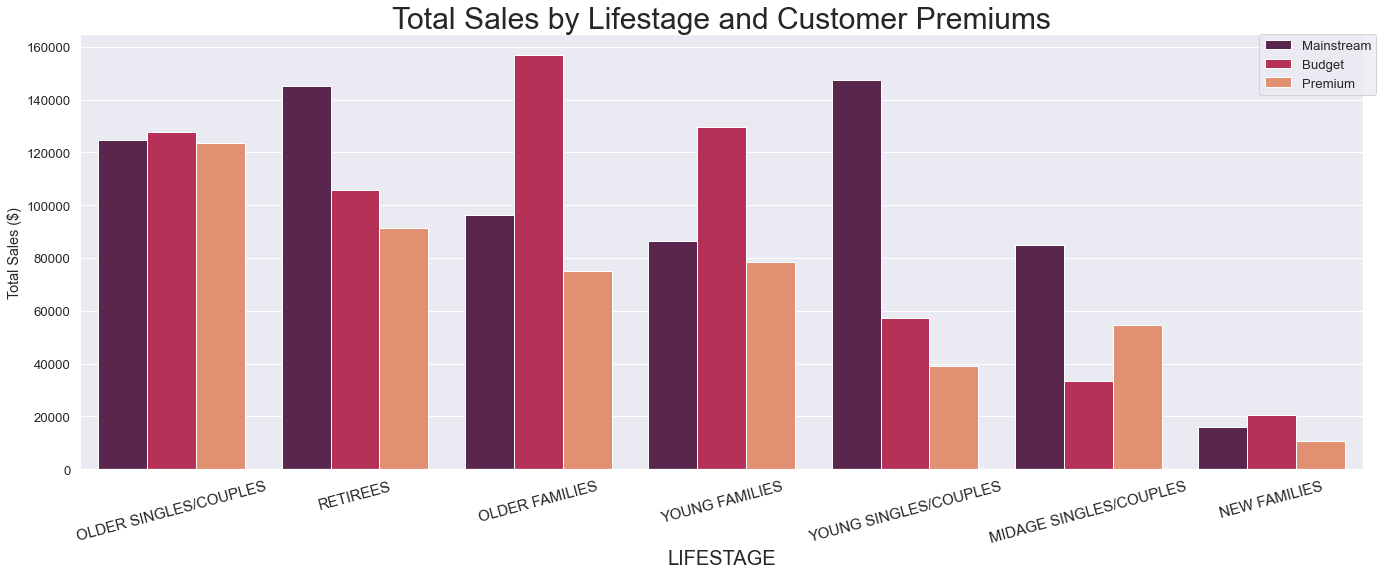

In [137]:
plt.figure(figsize = (23,8))
ax = sns.barplot(y = 'tot_sales', x = 'LIFESTAGE', data = viz_df, hue = 'PREMIUM', palette = 'rocket')
plt.xticks(fontsize = 15, rotation = 15)
plt.ylabel('Total Sales ($)')
plt.xlabel('LIFESTAGE', fontsize = 20)
plt.title('Total Sales by Lifestage and Customer Premiums', fontsize = 30)
plt.legend(bbox_to_anchor=(1.01, 1),
           borderaxespad=0)

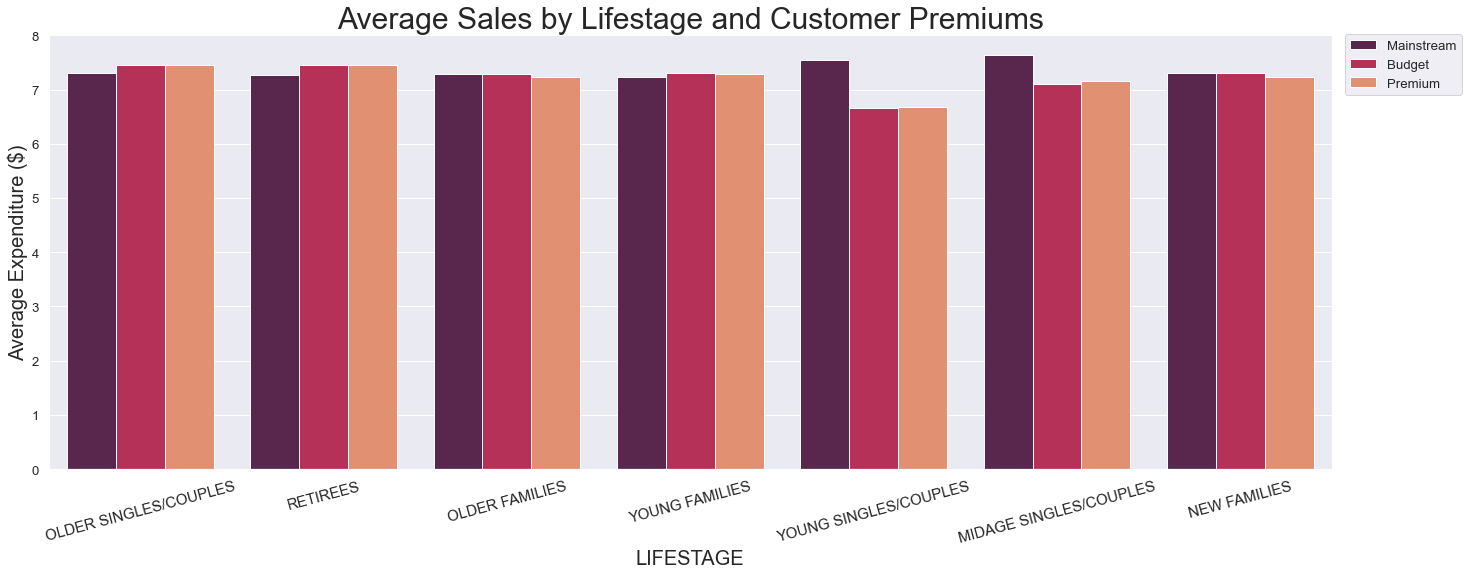

In [138]:
plt.figure(figsize = (23,8))
ax = sns.barplot(y = 'avg_sales', x = 'LIFESTAGE', data = viz_df, hue = 'PREMIUM', palette = 'rocket')
plt.xticks(fontsize = 15, rotation = 15)
plt.xlabel('LIFESTAGE', fontsize = 20)
plt.ylabel('Average Expenditure ($)', fontsize = 20)
plt.title('Average Sales by Lifestage and Customer Premiums', fontsize = 30)
plt.legend(bbox_to_anchor=(1.01, 1),
           borderaxespad=0)

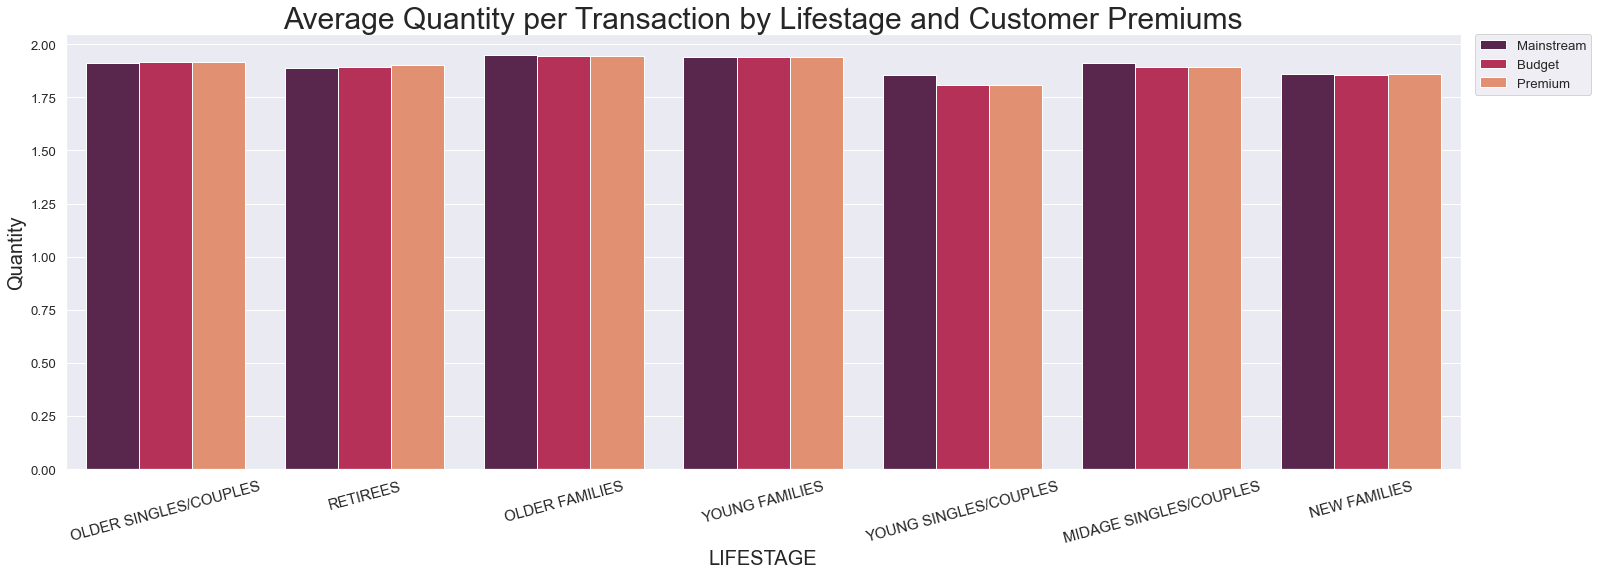

In [139]:
plt.figure(figsize = (25,8))
ax = sns.barplot(y = 'avg_qty', x = 'LIFESTAGE', data = viz_df, hue = 'PREMIUM', palette = 'rocket')
plt.xticks(fontsize = 15, rotation = 15)
plt.ylabel('Quantity',fontsize = 20)
plt.xlabel('LIFESTAGE', fontsize = 20)
plt.title('Average Quantity per Transaction by Lifestage and Customer Premiums', fontsize = 30)
plt.legend(bbox_to_anchor=(1.01, 1),
           borderaxespad=0)

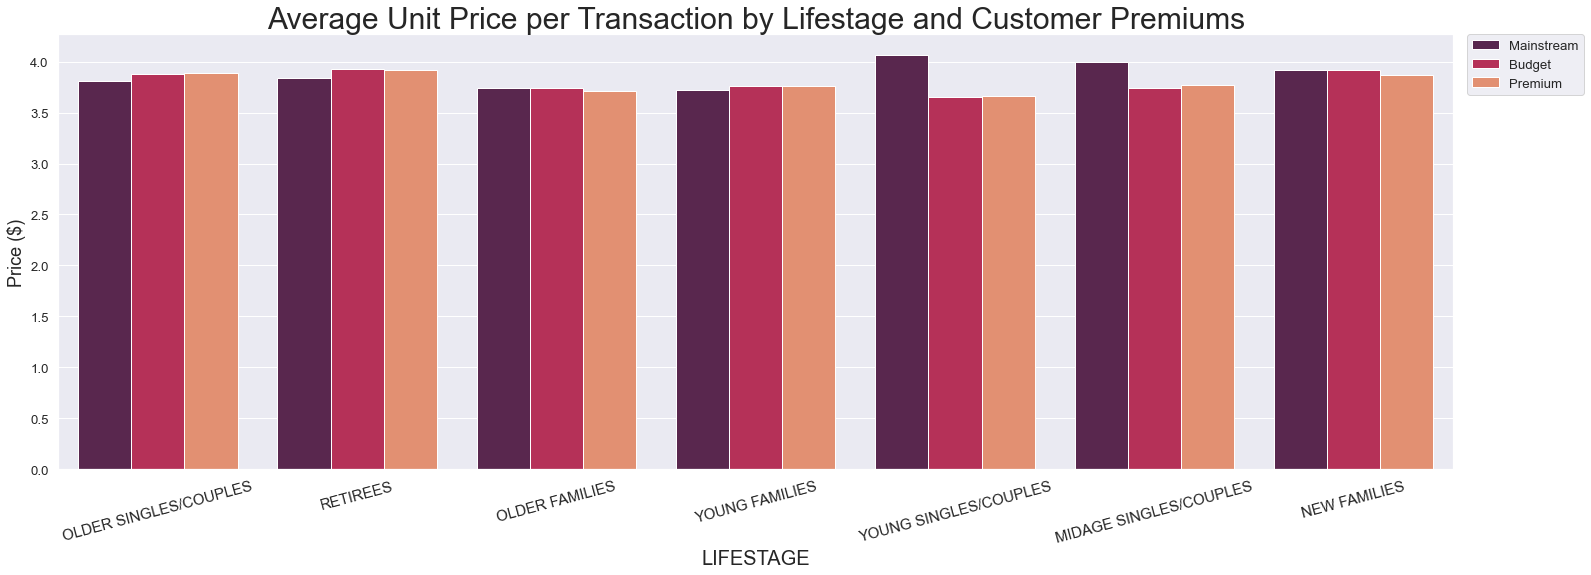

In [140]:
plt.figure(figsize = (25,8))
ax = sns.barplot(y = 'avg_unit_price', x = 'LIFESTAGE', data = viz_df, hue = 'PREMIUM', palette = 'rocket')
plt.xticks(fontsize = 15, rotation = 15)
plt.ylabel('Price ($)', fontsize = 18)
plt.xlabel('LIFESTAGE', fontsize = 20)
plt.title('Average Unit Price per Transaction by Lifestage and Customer Premiums', fontsize = 30)
plt.legend(bbox_to_anchor=(1.01, 1),
           borderaxespad=0)

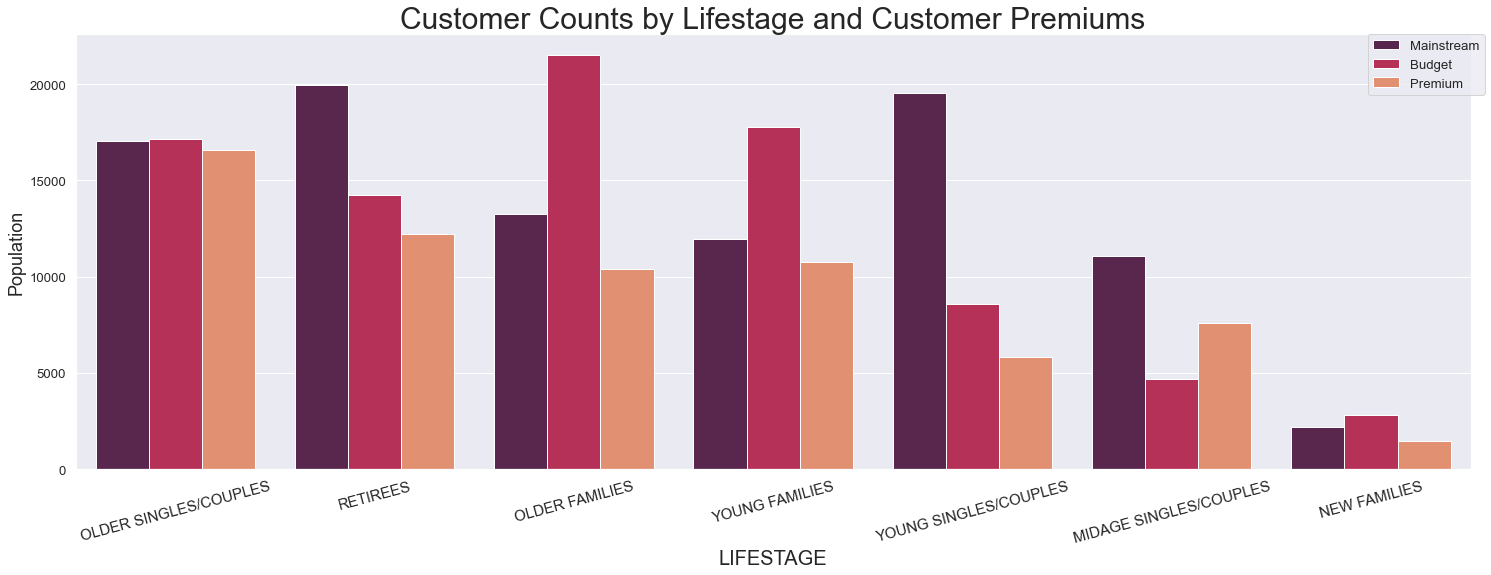

In [141]:
plt.figure(figsize = (25,8))
ax = sns.barplot(y = 'cust_count', x = 'LIFESTAGE', data = viz_df, hue = 'PREMIUM', palette = 'rocket')
plt.xticks(fontsize = 15, rotation = 15)
plt.ylabel('Population', fontsize = 18)
plt.xlabel('LIFESTAGE', fontsize = 20)
plt.title('Customer Counts by Lifestage and Customer Premiums', fontsize = 30)
plt.legend(bbox_to_anchor=(1.01, 1),
           borderaxespad=0)

                              Segment  Total_sales
10              OLDER FAMILIES Budget     156863.8
6    YOUNG SINGLES/COUPLES Mainstream     147582.2
0                 RETIREES Mainstream     145169.0
13              YOUNG FAMILIES Budget     129718.0
4        OLDER SINGLES/COUPLES Budget     127833.6
3    OLDER SINGLES/COUPLES Mainstream     124642.8
5       OLDER SINGLES/COUPLES Premium     123537.6
1                     RETIREES Budget     105916.3
9           OLDER FAMILIES Mainstream      96413.6
2                    RETIREES Premium      91296.6
12          YOUNG FAMILIES Mainstream      86338.2
15  MIDAGE SINGLES/COUPLES Mainstream      84734.2
14             YOUNG FAMILIES Premium      78571.7
11             OLDER FAMILIES Premium      75242.6
7        YOUNG SINGLES/COUPLES Budget      57117.9
17     MIDAGE SINGLES/COUPLES Premium      54443.8
8       YOUNG SINGLES/COUPLES Premium      39052.3
16      MIDAGE SINGLES/COUPLES Budget      33345.7
19                NEW FAMILIES 

Text(0.5, 1.0, 'Total Sales by Each Individual Segment')

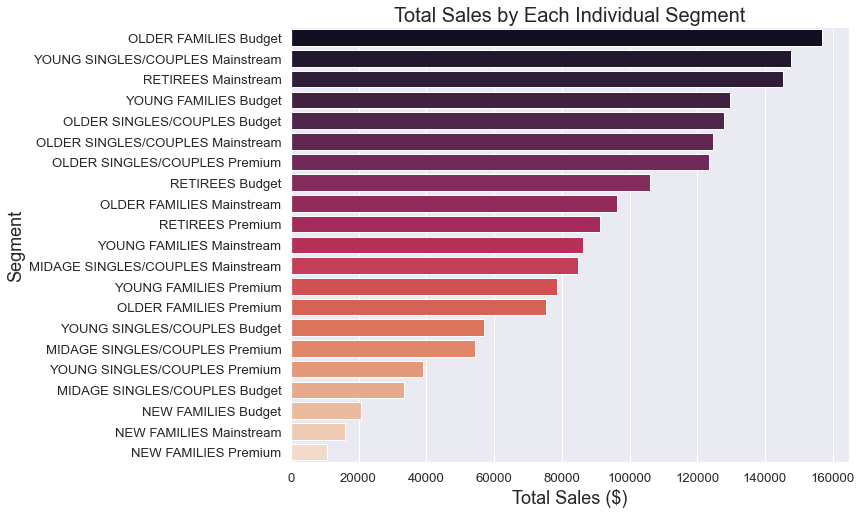

In [79]:
# Combined segments with most sales
sales = []
segs = []
for segment in lifestage['SEGMENT']:
    for prem in premium['Segment']:
        df = data[(data['LIFESTAGE'] == segment) & (data['PREMIUM_CUSTOMER'] == prem)]
        sales.append(round(np.sum(df['TOT_SALES']), 1))
        segs.append(f'{segment} {prem}')

# Make df for each individual segment
df_sales = pd.DataFrame(segs, columns = ['Segment'])
df_sales['Total_sales'] = sales
df_sales.sort_values(by = 'Total_sales', ascending = False, inplace = True)
print(df_sales)

# Plot segment sales
plt.figure(figsize = (10,8))
ax = sns.barplot(y = 'Segment', x = 'Total_sales', data = df_sales, palette = 'rocket')
ax.set_xlabel('Total Sales ($)', fontsize = 18)
ax.set_ylabel('Segment', fontsize = 18)
plt.title('Total Sales by Each Individual Segment', fontsize = 20)

OBSERVATIONS:
- The segments which spend the most include:
    - Older Families with Budget Premiums
    - Young singles/couples with Mainstream Premiums
    - Retirees with Mainstream Premiums

RECOMMENDATION:
- Target segments which provide the most sales.
- Find out their favorite brand of chips.
- Catering to these segments will further increase sales.

                              Segment  avg_qty
0                 RETIREES Mainstream      1.9
11             OLDER FAMILIES Premium      1.9
19                NEW FAMILIES Budget      1.9
18            NEW FAMILIES Mainstream      1.9
17     MIDAGE SINGLES/COUPLES Premium      1.9
16      MIDAGE SINGLES/COUPLES Budget      1.9
15  MIDAGE SINGLES/COUPLES Mainstream      1.9
14             YOUNG FAMILIES Premium      1.9
13              YOUNG FAMILIES Budget      1.9
12          YOUNG FAMILIES Mainstream      1.9
10              OLDER FAMILIES Budget      1.9
1                     RETIREES Budget      1.9
9           OLDER FAMILIES Mainstream      1.9
6    YOUNG SINGLES/COUPLES Mainstream      1.9
5       OLDER SINGLES/COUPLES Premium      1.9
4        OLDER SINGLES/COUPLES Budget      1.9
3    OLDER SINGLES/COUPLES Mainstream      1.9
2                    RETIREES Premium      1.9
20               NEW FAMILIES Premium      1.9
8       YOUNG SINGLES/COUPLES Premium      1.8
7        YOUN

Text(0.5, 1.0, 'Average Sales by Each Individual Segment')

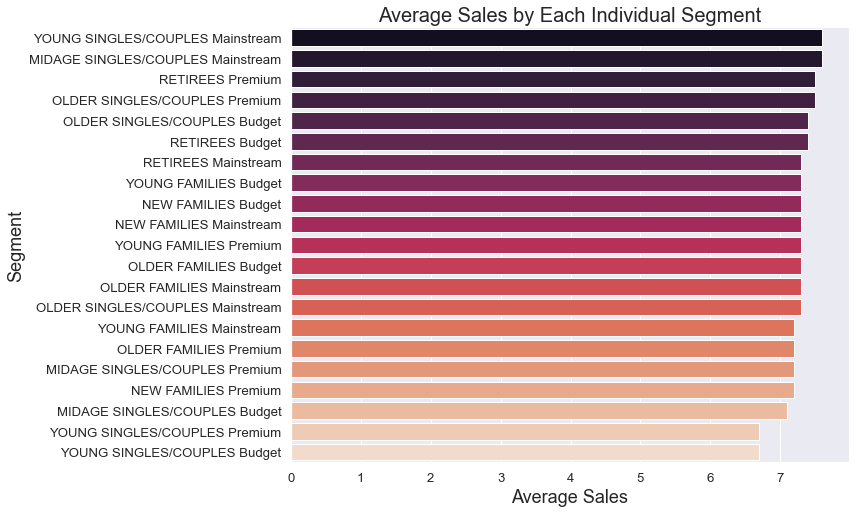

In [86]:
# Combined segments with most qty
qty = []
segs = []
for segment in lifestage['SEGMENT']:
    for prem in premium['Segment']:
        df = data[(data['LIFESTAGE'] == segment) & (data['PREMIUM_CUSTOMER'] == prem)]
        qty.append(round(np.mean(df['TOT_SALES']), 1))
        segs.append(f'{segment} {prem}')

# Make df for each individual segment
df_avg = pd.DataFrame(segs, columns = ['Segment'])
df_avg['avg_sales'] = qty
df_avg.sort_values(by = 'avg_sales', ascending = False, inplace = True)
print(df_qty)

# Plot segment sales
plt.figure(figsize = (10,8))
ax = sns.barplot(y = 'Segment', x = 'avg_sales', data = df_avg, palette = 'rocket')
ax.set_xlabel('Average Sales', fontsize = 18)
ax.set_ylabel('Segment', fontsize = 18)
plt.title('Average Sales by Each Individual Segment', fontsize = 20)

In [82]:
data

,real_date,STORE_NBR,TXN_ID,PROD_NAME,BRAND_NAME,PACKET_SIZE,PROD_QTY,TOT_SALES,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER,AVG_CHIP_PRICE
0,2018-07-01,9,8808,Smiths Thinly Cut Roast Chicken 175g,Smiths,175,2,6.0,9341,RETIREES,Budget,3.0
1,2018-07-01,86,84237,Red Rock Deli Sp Salt & Truffle 150G,RRD,150,2,5.4,86016,RETIREES,Mainstream,2.7
2,2018-07-01,129,132474,Smith Crinkle Cut Mac N Cheese 150g,Smiths,150,2,5.2,129046,OLDER SINGLES/COUPLES,Premium,2.6
3,2018-07-01,58,53145,Pringles Sthrn FriedChicken 134g,Pringles,134,2,7.4,58072,OLDER SINGLES/COUPLES,Premium,3.7
4,2018-07-01,97,97311,WW Crinkle Cut Chicken 175g,Woolworths,175,2,3.4,97164,OLDER FAMILIES,Premium,1.7
...,...,...,...,...,...,...,...,...,...,...,...,...
246735,2019-06-30,91,89519,Thins Chips Seasonedchicken 175g,Thins,175,2,6.6,91076,YOUNG SINGLES/COUPLES,Mainstream,3.3
246736,2019-06-30,84,83704,Doritos Corn Chips Nacho Cheese 170g,Doritos,170,2,8.8,84116,YOUNG SINGLES/COUPLES,Budget,4.4
246737,2019-06-30,24,20917,Smiths Crinkle Cut Chips Chs&Onion170g,Smiths,170,2,5.8,24115,YOUNG FAMILIES,Budget,2.9
246738,2019-06-30,199,198068,Doritos Corn Chips Nacho Cheese 170g,Doritos,170,2,8.8,199117,MIDAGE SINGLES/COUPLES,Mainstream,4.4


----------------------------------------
OLDER FAMILIES Budget Top Brands Ranked
----------------------------------------
Kettle          3320
Smiths          2948
Doritos         2032
Pringles        1996
RRD             1708
Woolworths      1213
Infuzions       1185
Thins           1171
Twisties         810
Cobs             760
NCC              741
Tostitos         705
GrnWves          671
Tyrrells         489
CCs              451
Cheezels         427
Sunbites         305
Cheetos          281
Burger Rings     159
French Fries     142
Name: BRAND_NAME, dtype: int64
----------------------------------------
Plot: OLDER FAMILIES Budget
----------------------------------------


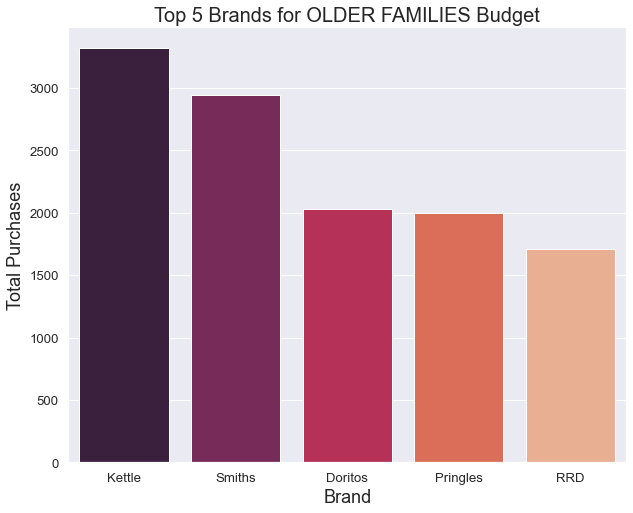

----------------------------------------
YOUNG SINGLES/COUPLES Mainstream Top Brands Ranked
----------------------------------------
Kettle          3844
Doritos         2379
Pringles        2315
Smiths          1921
Infuzions       1250
Thins           1166
Twisties         900
Tostitos         890
RRD              875
Cobs             864
GrnWves          646
Tyrrells         619
Woolworths       479
NCC              394
Cheezels         346
CCs              222
Cheetos          166
Sunbites         128
French Fries      78
Burger Rings      62
Name: BRAND_NAME, dtype: int64
----------------------------------------
Plot: YOUNG SINGLES/COUPLES Mainstream
----------------------------------------


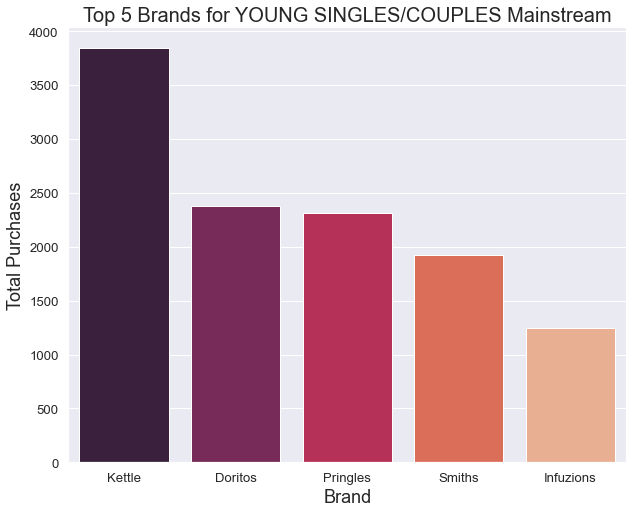

----------------------------------------
RETIREES Mainstream Top Brands Ranked
----------------------------------------
Kettle          3386
Smiths          2367
Pringles        2103
Doritos         2089
RRD             1223
Thins           1199
Infuzions       1182
Woolworths       902
Twisties         802
Cobs             776
Tostitos         739
GrnWves          667
NCC              587
Tyrrells         514
Cheezels         382
CCs              355
Sunbites         243
Cheetos          236
Burger Rings     122
French Fries      96
Name: BRAND_NAME, dtype: int64
----------------------------------------
Plot: RETIREES Mainstream
----------------------------------------


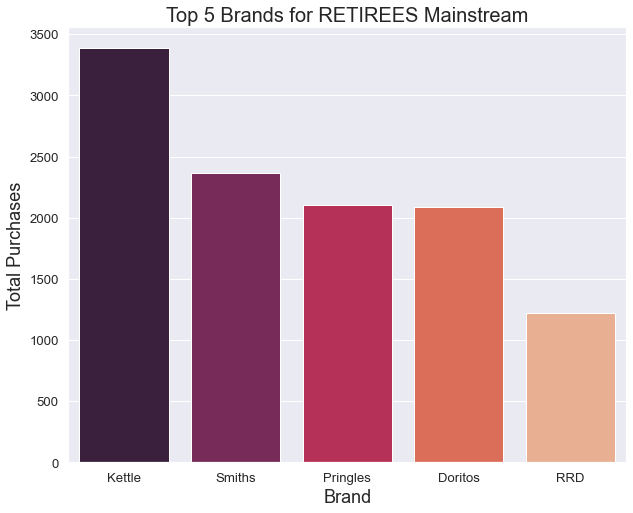

In [80]:
# top 3 segment premiums
prems = ['Budget', 'Mainstream', 'Mainstream']

# top 3 segment lifestages
lifestages = ['OLDER FAMILIES', 'YOUNG SINGLES/COUPLES', 'RETIREES']

# Visualization
for lifestage, prem in zip(lifestages, prems):
    df = data[(data['LIFESTAGE'] == lifestage) & (data['PREMIUM_CUSTOMER'] == prem)]
    print('----------------------------------------')
    segment = f'{lifestage} {prem}'
    print(lifestage, prem + ' Top Brands Ranked')
    print('----------------------------------------')
    print(df['BRAND_NAME'].value_counts())
    print('----------------------------------------')
    print(f'Plot: {segment}')
    print('----------------------------------------')
    viz = pd.DataFrame.from_dict(dict(df['BRAND_NAME'].value_counts()), orient= 'index', columns = ['Count'])
    # Show viz of top 5 brands
    values = viz['Count'][:5]
    labels = viz.index[:5]
    plt.figure(figsize = (10,8))
    ax = sns.barplot(x = labels, y = values, palette= 'rocket')
    ax.set_xlabel('Brand', fontsize = 18)
    ax.set_ylabel('Total Purchases', fontsize = 18)
    plt.title(f'Top 5 Brands for {segment}', fontsize = 20)
    plt.show()

OBSERVATIONS:

OLDER FAMILIES Budget top brands:
- Kettle
- Smiths
- Doritos
- Pringles
- Red Rock Deli

YOUNG SINGLES/COUPLES Mainstream top brands:
- Kettle
- Smiths
- Doritos
- Pringles
- Red Rock Deli

RETIREES Mainstream Top Brands:
- Kettle
- Smiths
- Pringles
- Doritos
- Red Rock Deli

RECOMMENDATIONS:
- Promote these brands to increase sales.



In [81]:
for i in data.columns:
    print(i)

real_date
STORE_NBR
TXN_ID
PROD_NAME
BRAND_NAME
PACKET_SIZE
PROD_QTY
TOT_SALES
LYLTY_CARD_NBR
LIFESTAGE
PREMIUM_CUSTOMER
AVG_CHIP_PRICE


----------------------------------------
OLDER FAMILIES Budget Favorite Chip Sizes
----------------------------------------
175    5808
150    3588
134    1996
110    1803
170    1786
165    1358
330    1092
270     532
380     510
210     505
200     448
190     312
160     306
90      305
250     278
135     268
180     166
220     159
125     152
70      142
Name: PACKET_SIZE, dtype: int64
----------------------------------------
Plot: OLDER FAMILIES Budget
----------------------------------------


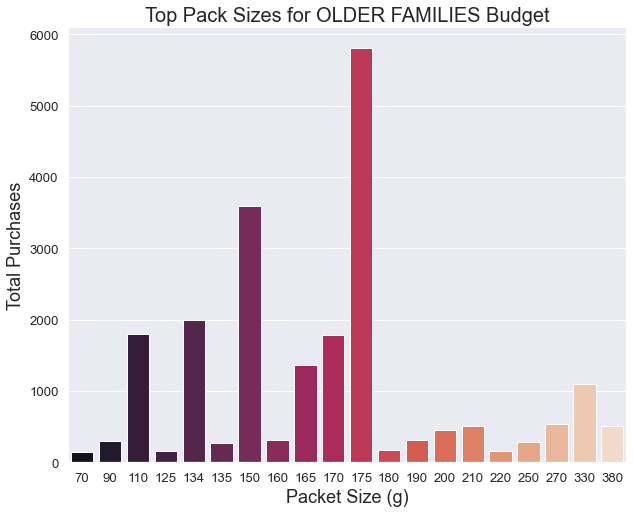

----------------------------------------
YOUNG SINGLES/COUPLES Mainstream Favorite Chip Sizes
----------------------------------------
175    4997
150    3080
134    2315
110    2051
170    1575
330    1195
165    1102
380     626
270     620
210     576
135     290
250     280
200     179
190     148
90      128
160     128
180      70
70       63
220      62
125      59
Name: PACKET_SIZE, dtype: int64
----------------------------------------
Plot: YOUNG SINGLES/COUPLES Mainstream
----------------------------------------


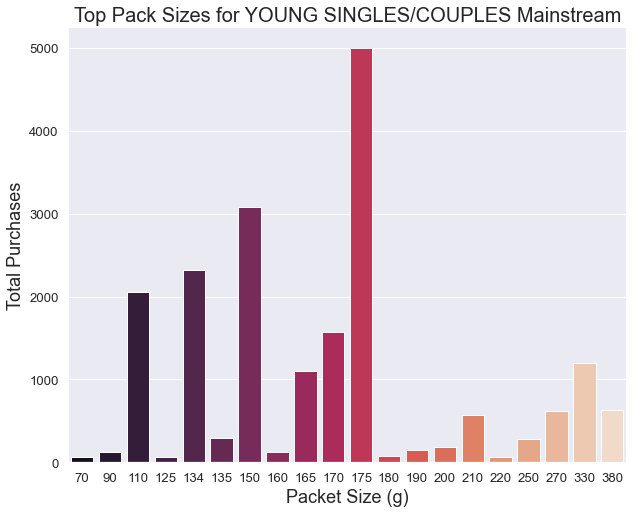

----------------------------------------
RETIREES Mainstream Favorite Chip Sizes
----------------------------------------
175    5295
150    3290
134    2103
110    1829
170    1636
165    1182
330    1010
210     540
270     514
380     497
200     342
250     288
135     263
90      243
160     221
190     218
70      129
180     127
220     122
125     121
Name: PACKET_SIZE, dtype: int64
----------------------------------------
Plot: RETIREES Mainstream
----------------------------------------


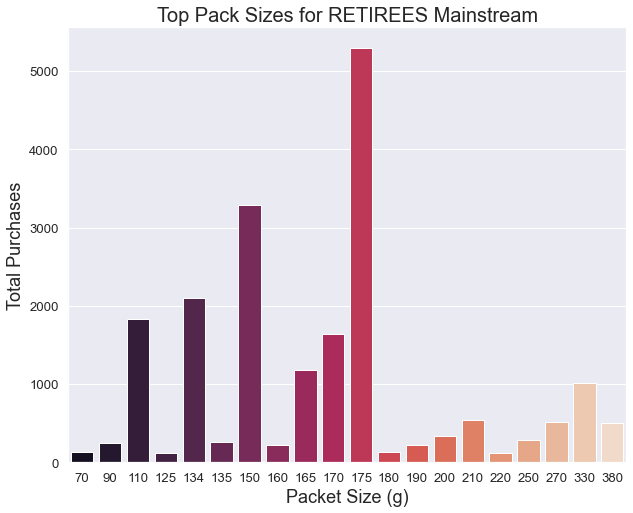

In [82]:
# Check Prefered Pack size per top ranked segments

# top 3 segment premiums
prems = ['Budget', 'Mainstream', 'Mainstream']

# top 3 segment lifestages
lifestages = ['OLDER FAMILIES', 'YOUNG SINGLES/COUPLES', 'RETIREES']

# Visualization
for lifestage, prem in zip(lifestages, prems):
    df = data[(data['LIFESTAGE'] == lifestage) & (data['PREMIUM_CUSTOMER'] == prem)]
    print('----------------------------------------')
    segment = f'{lifestage} {prem}'
    print(lifestage, prem + ' Favorite Chip Sizes')
    print('----------------------------------------')
    print(df['PACKET_SIZE'].value_counts())
    print('----------------------------------------')
    print(f'Plot: {segment}')
    print('----------------------------------------')
    viz = pd.DataFrame.from_dict(dict(df['PACKET_SIZE'].value_counts()), orient= 'index', columns = ['Count'])
    # Show viz of top 5 brands
    values = viz['Count']
    labels = viz.index
    plt.figure(figsize = (10,8))
    ax = sns.barplot(x = labels, y = values, palette= 'rocket')
    ax.set_xlabel('Packet Size (g)', fontsize = 18)
    ax.set_ylabel('Total Purchases', fontsize = 18)
    plt.title(f'Top Pack Sizes for {segment}', fontsize = 20)
    plt.show()

OBSERVATIONS:
- Across all 3 top segments, the most popular pack sizes are:
    - 175g
    - 150g
    - 134g

RECOMMENDATIONS:
- Prioritize these pack sizes when replenishing stock.

In [83]:
data.to_csv('QVI_clean_data.csv')

In [86]:
lifestage

'RETIREES'

In [97]:
data

,real_date,STORE_NBR,TXN_ID,PROD_NAME,BRAND_NAME,PACKET_SIZE,PROD_QTY,TOT_SALES,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER,AVG_CHIP_PRICE
0,2018-07-01,9,8808,Smiths Thinly Cut Roast Chicken 175g,Smiths,175,2,6.0,9341,RETIREES,Budget,3.0
1,2018-07-01,86,84237,Red Rock Deli Sp Salt & Truffle 150G,RRD,150,2,5.4,86016,RETIREES,Mainstream,2.7
2,2018-07-01,129,132474,Smith Crinkle Cut Mac N Cheese 150g,Smiths,150,2,5.2,129046,OLDER SINGLES/COUPLES,Premium,2.6
3,2018-07-01,58,53145,Pringles Sthrn FriedChicken 134g,Pringles,134,2,7.4,58072,OLDER SINGLES/COUPLES,Premium,3.7
4,2018-07-01,97,97311,WW Crinkle Cut Chicken 175g,Woolworths,175,2,3.4,97164,OLDER FAMILIES,Premium,1.7
...,...,...,...,...,...,...,...,...,...,...,...,...
246735,2019-06-30,91,89519,Thins Chips Seasonedchicken 175g,Thins,175,2,6.6,91076,YOUNG SINGLES/COUPLES,Mainstream,3.3
246736,2019-06-30,84,83704,Doritos Corn Chips Nacho Cheese 170g,Doritos,170,2,8.8,84116,YOUNG SINGLES/COUPLES,Budget,4.4
246737,2019-06-30,24,20917,Smiths Crinkle Cut Chips Chs&Onion170g,Smiths,170,2,5.8,24115,YOUNG FAMILIES,Budget,2.9
246738,2019-06-30,199,198068,Doritos Corn Chips Nacho Cheese 170g,Doritos,170,2,8.8,199117,MIDAGE SINGLES/COUPLES,Mainstream,4.4
